<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/Copy_of_Vanilla_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
From "Building a Vanilla GAN with Pytorch" by Fancesco Franco in Medium, Nov 24
'''
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import uuid
import time

# Configuration variables
#NUM_EPOCHS = 50
NUM_EPOCHS = 10
NOISE_DIMENSION = 50
BATCH_SIZE = 128
TRAIN_ON_GPU = True
UNIQUE_RUN_ID = str(uuid.uuid4())
PRINT_STATS_AFTER_BATCH = 50
OPTIMIZER_LR = 0.0002
#DEVICE = torch.device("cuda" if TRAIN_ON_GPU and torch.cuda.is_available() else "cpu")
OPTIMIZER_BETAS = (0.5, 0.999)
GENERATOR_OUTPUT_IMAGE_SHAPE = 28 * 28 * 1

# PyTorch speedups
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

# Building the Generator
class Generator(nn.Module):
  """
    Vanilla GAN Generator
  """
  def __init__(self,):
    super().__init__()
    self.layers = nn.Sequential(
        # First upsampling
        nn.Linear(NOISE_DIMENSION, 128, bias=False),
        nn.BatchNorm1d(128, 0.8),
        nn.LeakyReLU(0.25),
        # Second upsampling
        nn.Linear(128, 256, bias=False),
        nn.BatchNorm1d(256, 0.8),
        nn.LeakyReLU(0.25),
        # Third upsampling
        nn.Linear(256,512, bias=False),
        nn.BatchNorm1d(512, 0.8),
        nn.LeakyReLU(0.25),
        # Final upsampling
        nn.Linear(512, GENERATOR_OUTPUT_IMAGE_SHAPE, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    """Forward pass"""
    return self.layers(x)

# Building the Discriminator
class Discriminator(nn.Module):
  """
        Vanilla GAN Discriminator
  """
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(GENERATOR_OUTPUT_IMAGE_SHAPE, 1024),
        nn.LeakyReLU(0.25),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.25),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.25),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    """Forward pass"""
    return self.layers(x)



In [ ]:
def get_device():
  """ Retreive device based on settings and avialability """
  if TRAIN_ON_GPU and torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def make_directory_for_run():
  """ Make directory for this training run"""
  print(f'Preparing training run {UNIQUE_RUN_ID}')
  if not os.path.exists('./runs'):
    os.mkdir('./runs')
  os.mkdir(f'./runs/{UNIQUE_RUN_ID}')

def generate_image(generator, epoch = 0, batch = 0, device=get_device()):
  """ Generate subplots with generated examples. """
  images = []
  noise = generate_noise(BATCH_SIZE, device=device)
  generator.eval()
  images = generator(noise)
  plt.figure(figsize=(10, 10))
  for i in range(16):
    # Get image
    image = images[i]
    # Convert image back onto CPU and reshape
    image = image.cpu().detach().numpy()
    image = np.reshape(image, (28, 28))
    # Plot
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
  if not os.path.exists(f'./runs/{UNIQUE_RUN_ID}/images'):
    os.mkdir(f'./runs/{UNIQUE_RUN_ID}/images')
  plt.savefig(f'./runs/{UNIQUE_RUN_ID}/images/epoch{epoch}_batch{batch}.jpg')


def save_models(generator, discriminator, epoch):
  """ Save models at specific point in time. """
  torch.save(generator.state_dict(), f'./runs/{UNIQUE_RUN_ID}/generator_{epoch}.pth')
  torch.save(discriminator.state_dict(), f'./runs/{UNIQUE_RUN_ID}/discriminator_{epoch}.pth')


def print_training_progress(batch, generator_loss, discriminator_loss):
  """ Print training progress. """
  print('Losses after mini-batch %5d: generator %e, discriminator %e' %
        (batch, generator_loss, discriminator_loss))



Pepare the dataset

In [ ]:
def prepare_dataset():
  """ Prepare dataset through DataLoader """
  # Prepare MNIST dataset
  dataset = MNIST(os.getcwd(), download=True, train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ]))
  # Batch and shuffle data with DataLoader

  #trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
  # Return dataset through DataLoader
  return trainloader


Initializing functions

In [ ]:
def initialize_models(device = get_device()):
  """ Initialize Generator and Discriminator models """
  generator = Generator()
  discriminator = Discriminator()
  # Move models to specific device
  generator.to(device)
  discriminator.to(device)
  # Return models
  return generator, discriminator


def initialize_loss():
  """ Initialize loss function. """
  return nn.BCELoss()


def initialize_optimizers(generator, discriminator):
  """ Initialize optimizers for Generator and Discriminator. """
  generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)
  discriminator_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)
  return generator_optimizer, discriminator_optimizer

Forward and backward pass

In [ ]:
def generate_noise(number_of_images = 1, noise_dimension = NOISE_DIMENSION, device=None):
  """ Generate noise for number_of_images images, with a specific noise_dimension """
  return torch.randn(number_of_images, noise_dimension, device=device)


def efficient_zero_grad(model):
  """
    Apply zero_grad more efficiently
    Source: https://betterprogramming.pub/how-to-make-your-pytorch-code-run-faster-93079f3c1f7b
  """
  for param in model.parameters():
    param.grad = None


def forward_and_backward(model, data, loss_function, targets):
  """
    Perform forward and backward pass in a generic way. Returns loss value.
  """
  outputs = model(data)
  error = loss_function(outputs, targets)
  error.backward()
  return error.item()

Performing a training step

In [ ]:
def perform_train_step(generator, discriminator, real_data, \
  loss_function, generator_optimizer, discriminator_optimizer, device = get_device()):
  """ Perform a single training step. """

  # 1. PREPARATION
  # Set real and fake labels.
  real_label, fake_label = 1.0, 0.0
  # Get images on CPU or GPU as configured and available
  # Also set 'actual batch size', whih can be smaller than BATCH_SIZE
  # in some cases.
  real_images = real_data[0].to(device)
  actual_batch_size = real_images.size(0)
  label = torch.full((actual_batch_size,1), real_label, device=device)

  # 2. TRAINING THE DISCRIMINATOR
  # Zero the gradients for discriminator
  efficient_zero_grad(discriminator)
  # Forward + backward on real images, reshaped
  real_images = real_images.view(real_images.size(0), -1)
  error_real_images = forward_and_backward(discriminator, real_images, \
    loss_function, label)
  # Forward + backward on generated images
  noise = generate_noise(actual_batch_size, device=device)
  generated_images = generator(noise)
  label.fill_(fake_label)
  error_generated_images =forward_and_backward(discriminator, \
    generated_images.detach(), loss_function, label)
  # Optim for discriminator
  discriminator_optimizer.step()

  # 3. TRAINING THE GENERATOR
  # Forward + backward + optim for generator, including zero grad
  efficient_zero_grad(generator)
  label.fill_(real_label)
  error_generator = forward_and_backward(discriminator, generated_images, loss_function, label)
  generator_optimizer.step()

  # 4. COMPUTING RESULTS
  # Compute loss values in floats for discriminator, which is joint loss.
  error_discriminator = error_real_images + error_generated_images
  # Return generator and discriminator loss so that it can be printed.
  return error_generator, error_discriminator

Starting the training

In [ ]:
def perform_epoch(dataloader, generator, discriminator, loss_function, \
    generator_optimizer, discriminator_optimizer, epoch):
  """ Perform a single epoch. """
  for batch_no, real_data in enumerate(dataloader, 0):
    # Perform training step
    generator_loss_val, discriminator_loss_val = perform_train_step(generator, \
      discriminator, real_data, loss_function, \
      generator_optimizer, discriminator_optimizer)
    # Print statistics and generate image after every n-th batch
    if batch_no % PRINT_STATS_AFTER_BATCH == 0:
      print_training_progress(batch_no, generator_loss_val, discriminator_loss_val)
      generate_image(generator, epoch, batch_no)
  # Save models on epoch completion.
  save_models(generator, discriminator, epoch)
  # Clear memory after every epoch
  torch.cuda.empty_cache()

Preparing training run 711815c0-cc4d-4973-88a4-e5d5c6257b4f
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 3.70MB/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.45MB/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw

Starting epoch 0...
Losses after mini-batch     0: generator 6.745945e-01, discriminator 1.373560e+00
Losses after mini-batch    50: generator 8.643941e-01, discriminator 1.189710e+00
Losses after mini-batch   100: generator 1.394110e+00, discriminator 7.033307e-01
Losses after mini-batch   150: generator 9.906864e-01, discriminator 1.520309e+00
Losses after mini-batch   200: generator 2.779585e+00, discriminator 1.207288e-01
Losses after mini-batch   250: generator 1.663218e+00, discriminator 4.364412e-01
Losses after mini-batch   300: generator 1.052581e+00, discriminator 5.254510e-01
Losses after mini-batch   350: generator 3.914628e+00, discriminator 1.464555e-01
Losses after mini-batch   400: generator 5.505055e-01, discriminator 1.979106e+00
Losses after mini-batch   450: generator 4.590133e+00, discriminator 1.767796e-01
Starting epoch 1...
Losses after mini-batch     0: generator 4.444378e+00, discri

<ipython-input-2-40242be16cd0>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


Losses after mini-batch    50: generator 1.419113e+01, discriminator 1.758726e+00
Losses after mini-batch   100: generator 7.692656e+00, discriminator 2.891115e-01
Losses after mini-batch   150: generator 4.471076e+00, discriminator 5.225648e-02
Losses after mini-batch   200: generator 6.283485e+00, discriminator 2.311667e+00
Losses after mini-batch   250: generator 8.232005e+00, discriminator 4.814599e-01
Losses after mini-batch   300: generator 3.841653e+00, discriminator 2.534972e-01
Losses after mini-batch   350: generator 4.123634e+00, discriminator 1.085658e+00
Losses after mini-batch   400: generator 5.567393e-01, discriminator 3.395386e+00
Losses after mini-batch   450: generator 4.700039e+00, discriminator 1.506677e-01
Starting epoch 3...
Losses after mini-batch     0: generator 2.167812e+00, discriminator 2.552991e-01
Losses after mini-batch    50: generator 2.696716e+00, discriminator 2.123598e-01
Losses after mini-batch   100: generator 3.665972e+00, discriminator 1.565811e

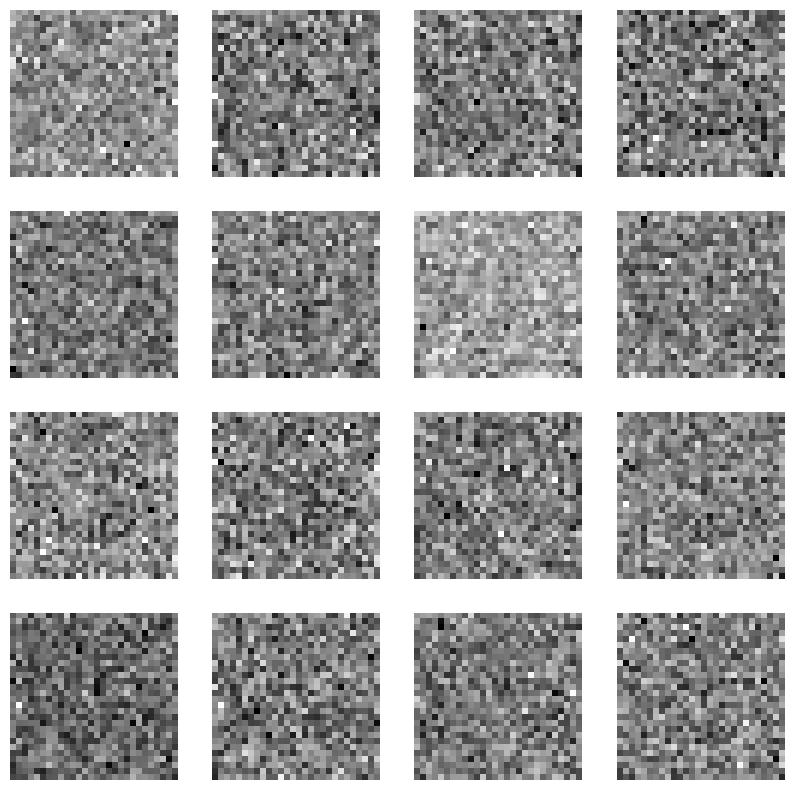

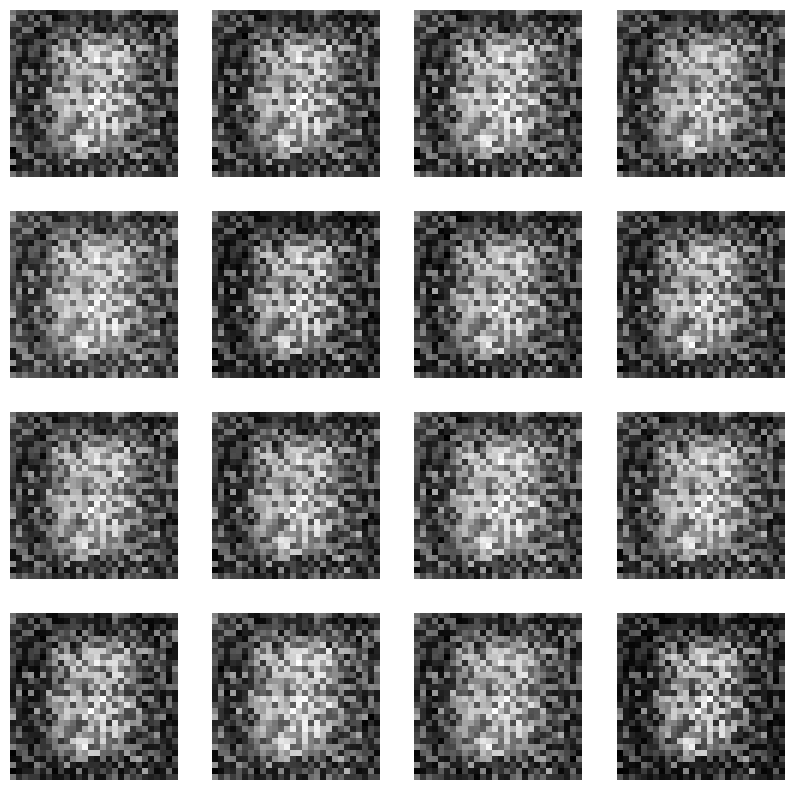

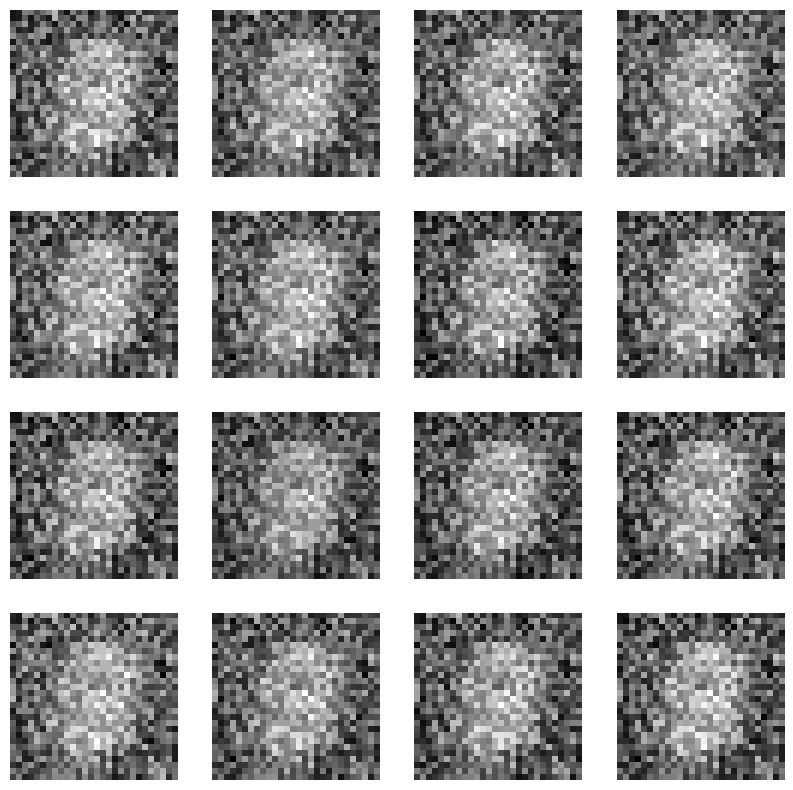

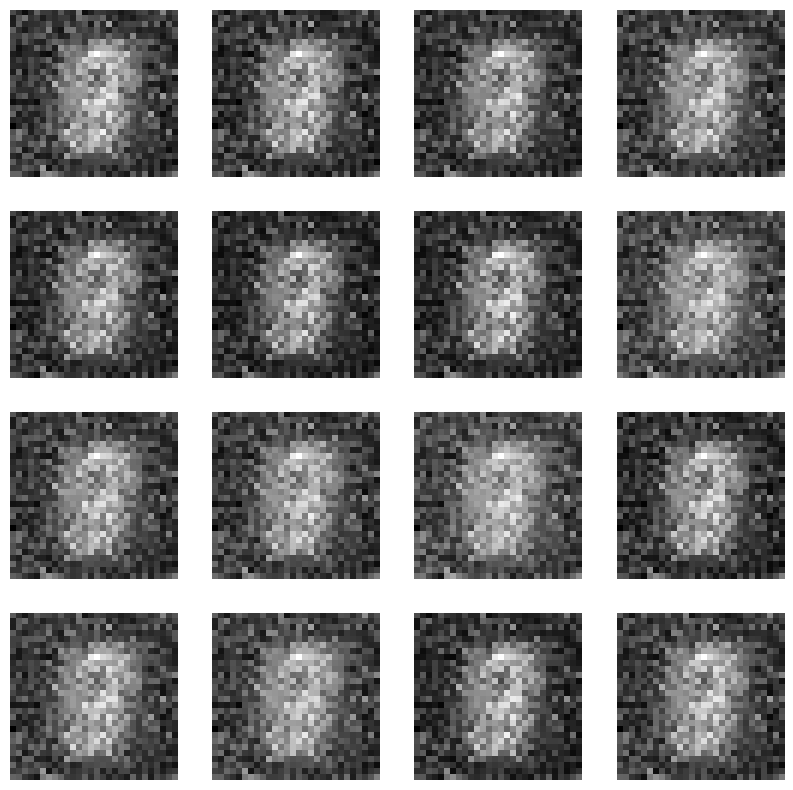

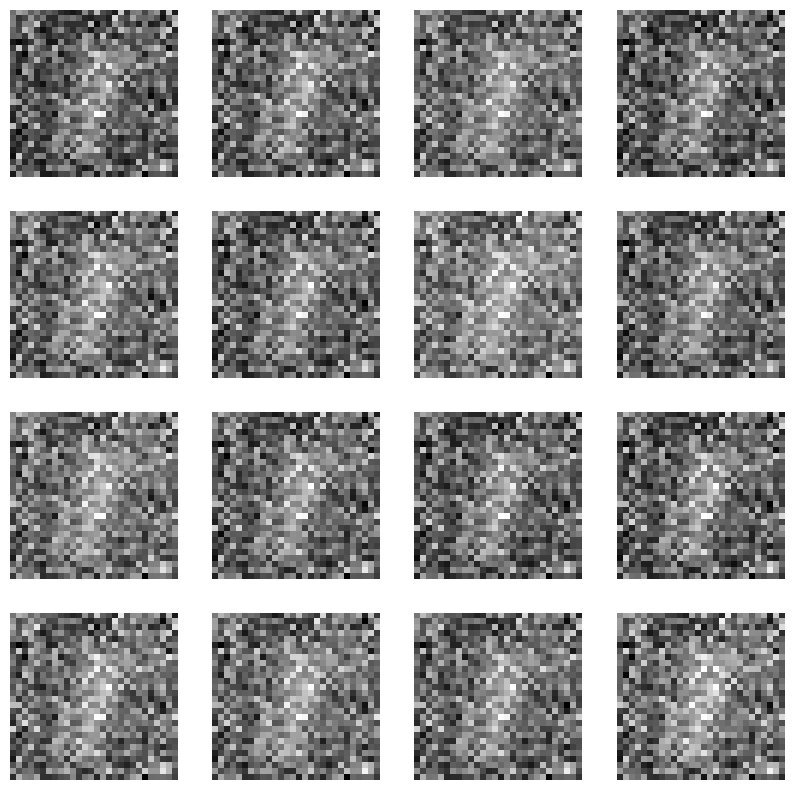

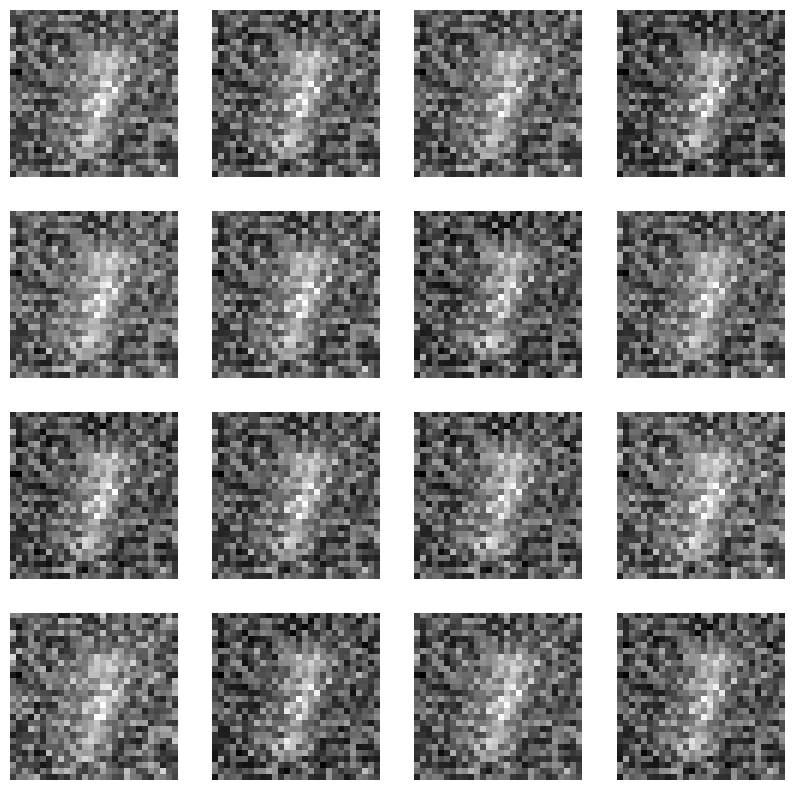

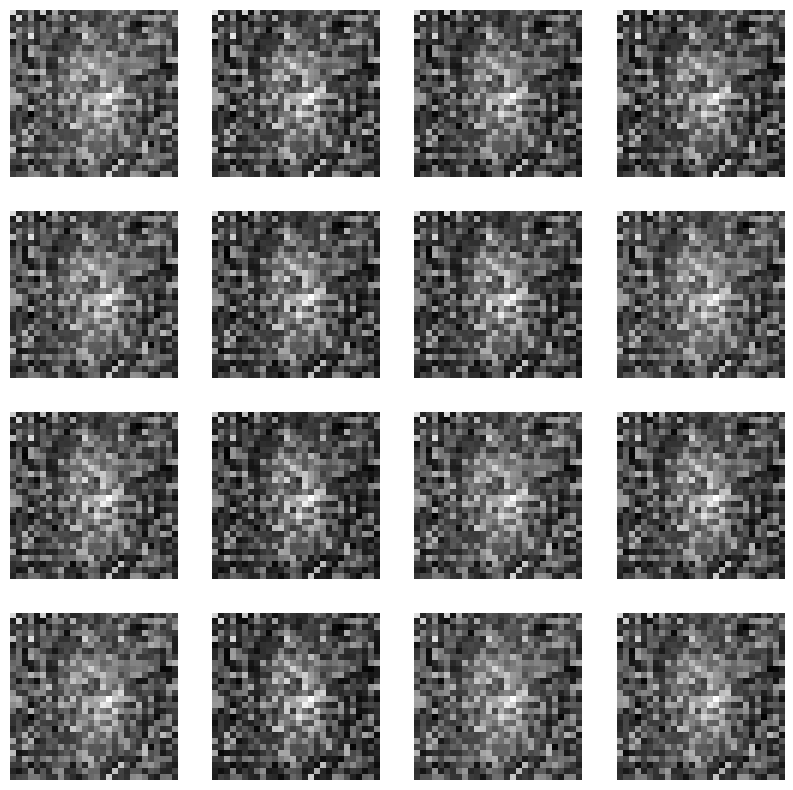

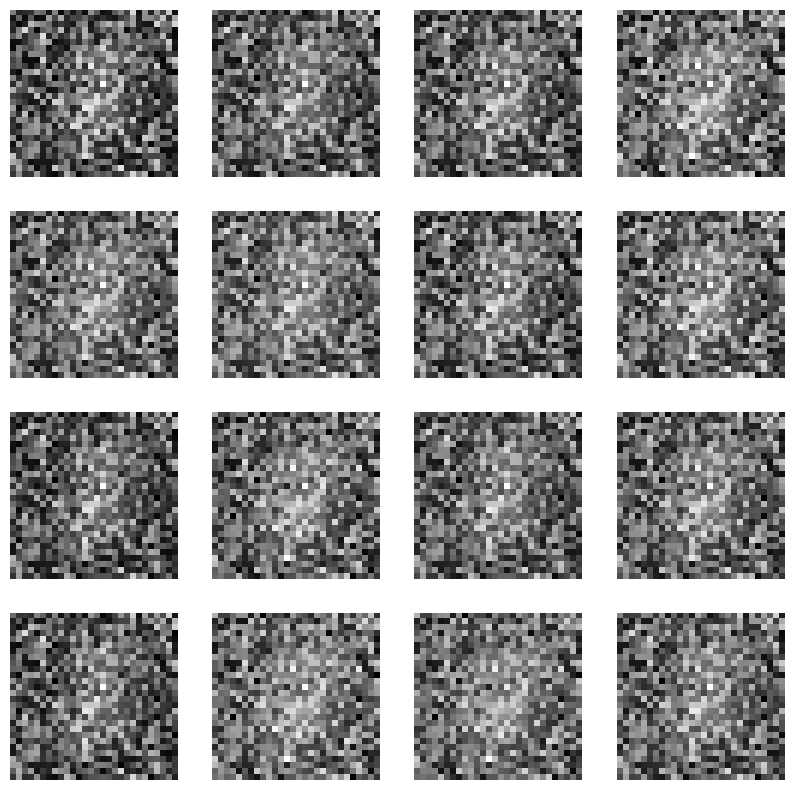

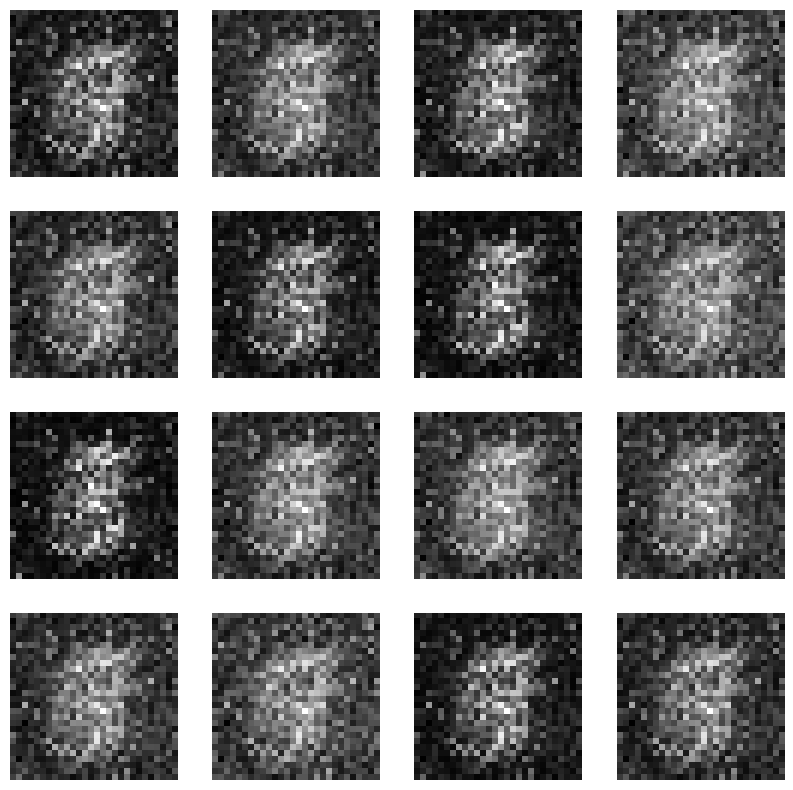

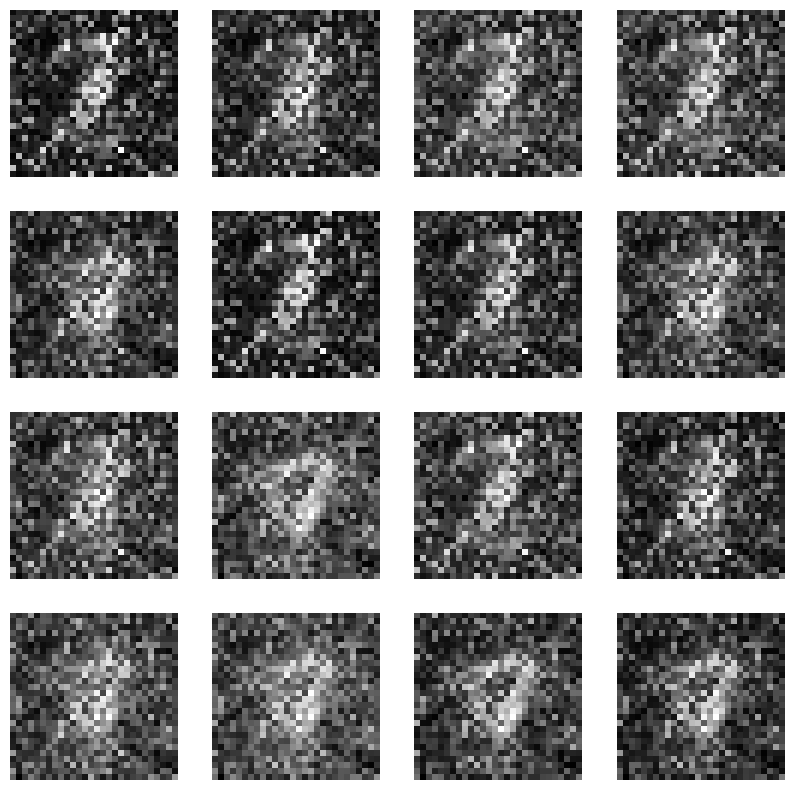

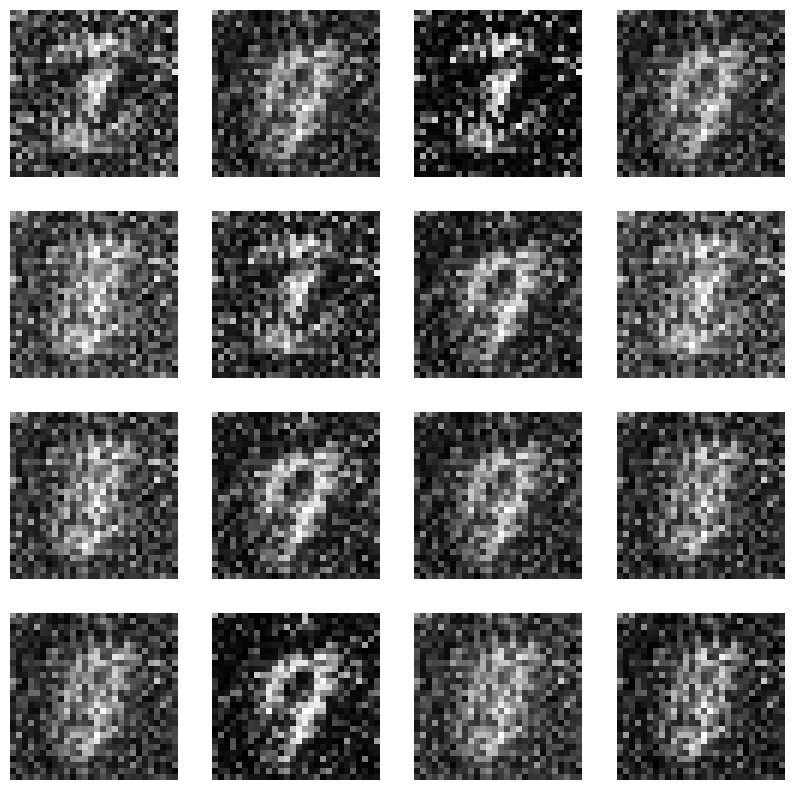

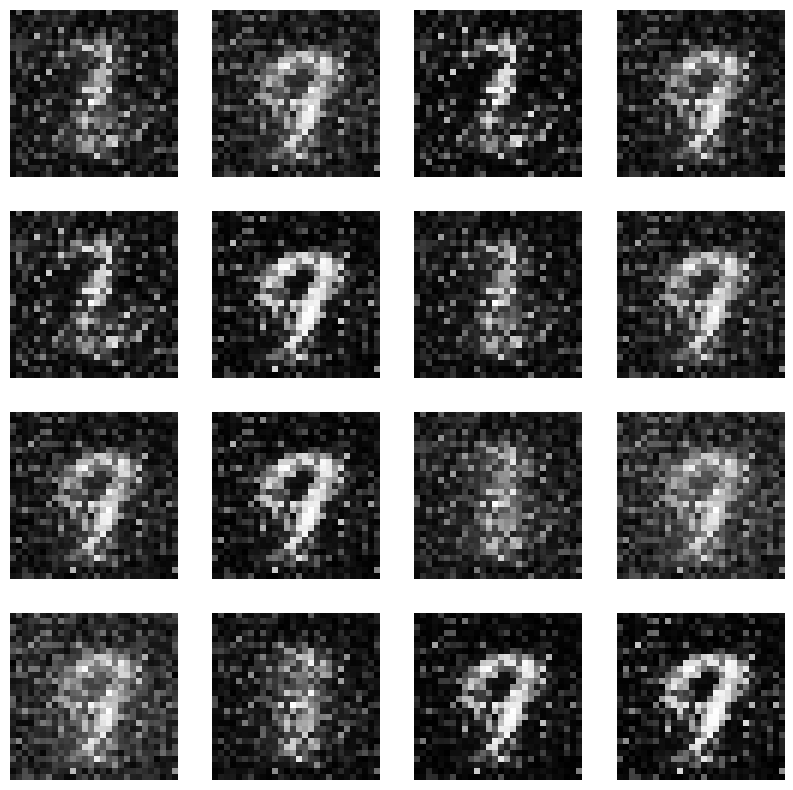

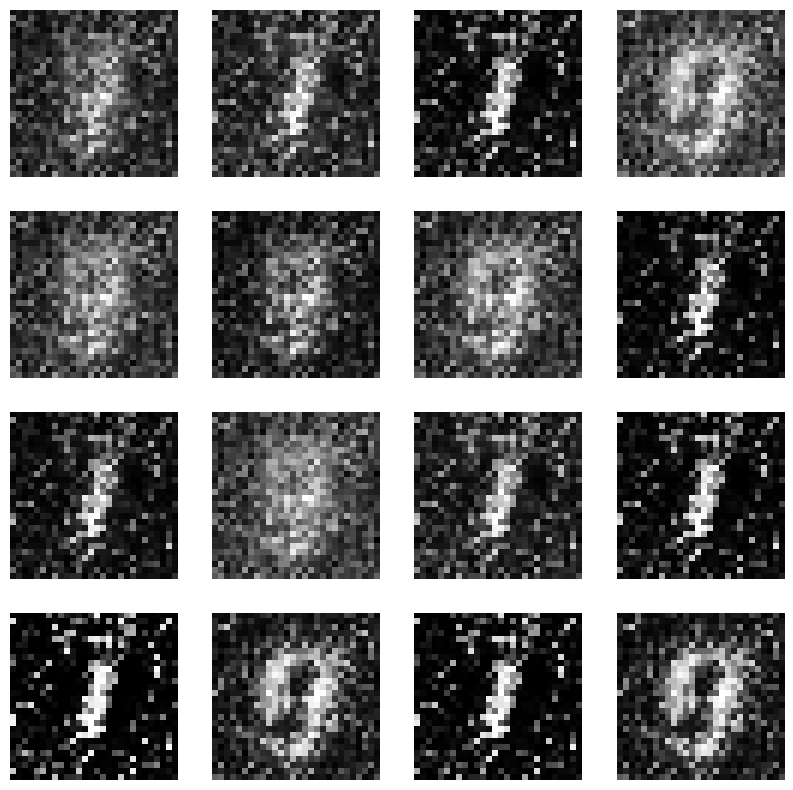

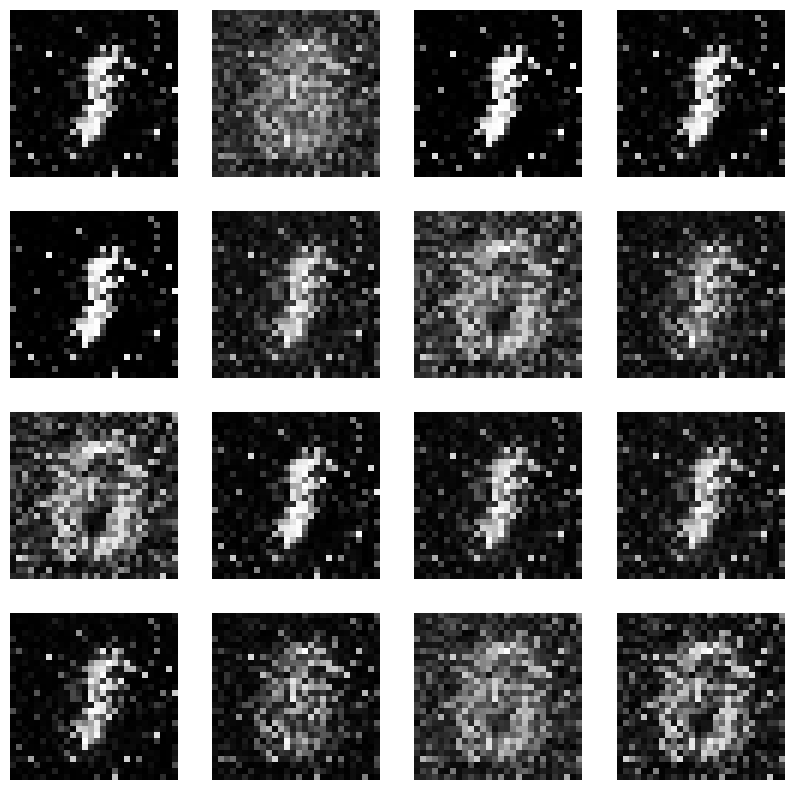

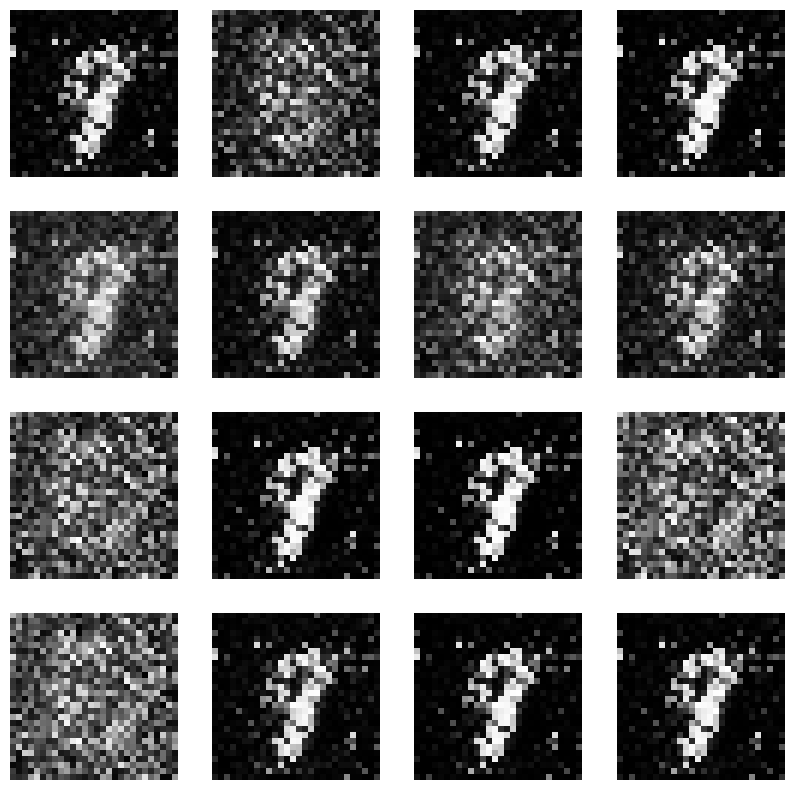

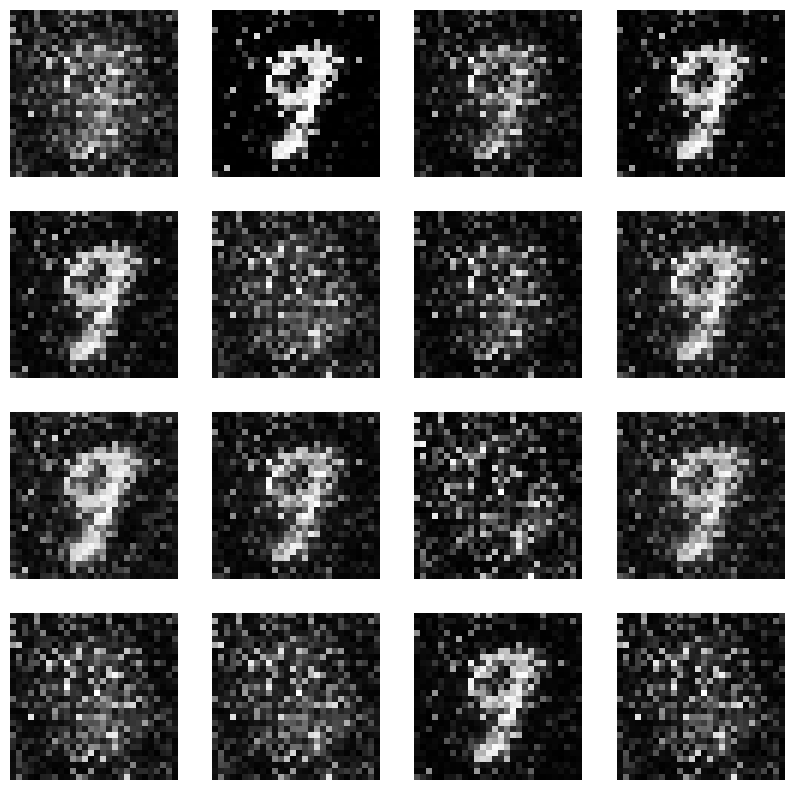

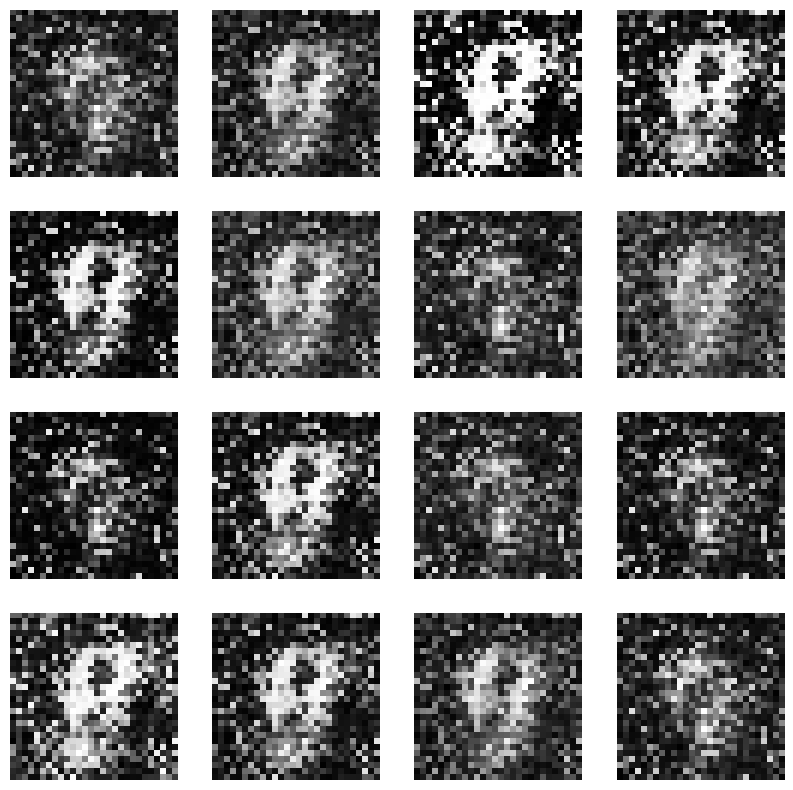

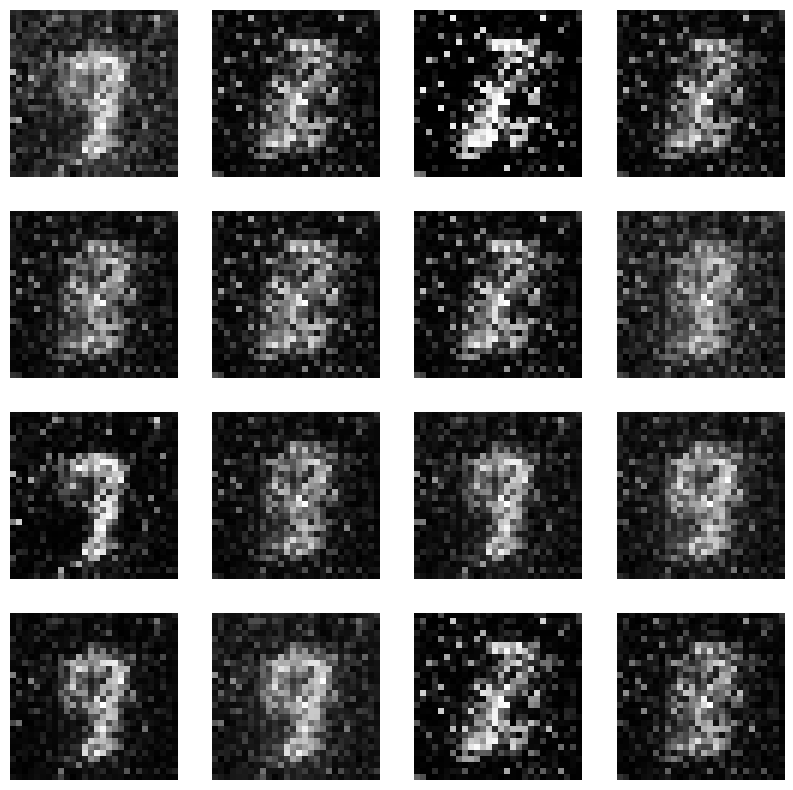

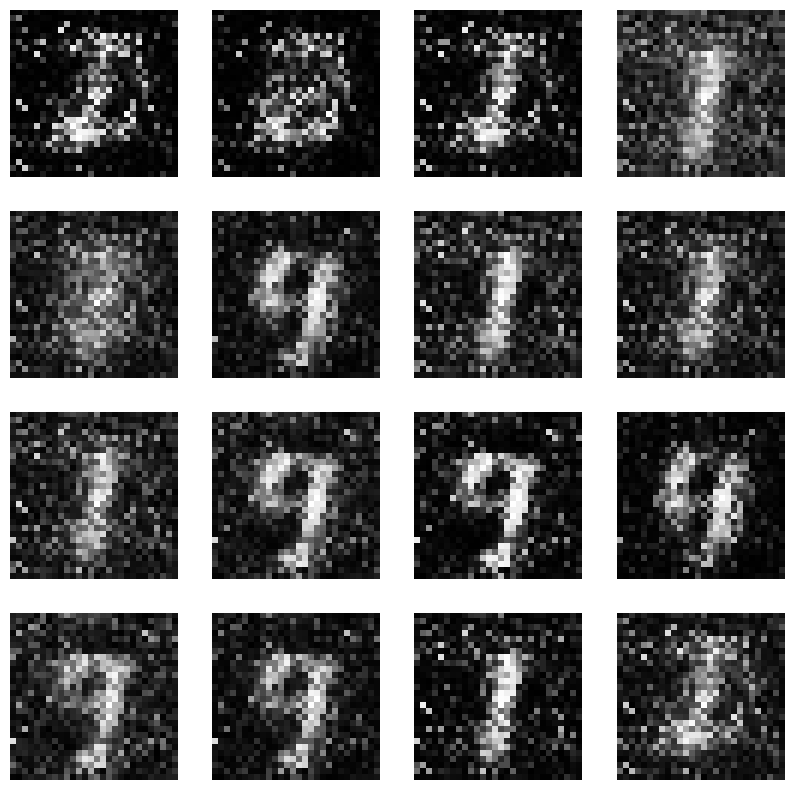

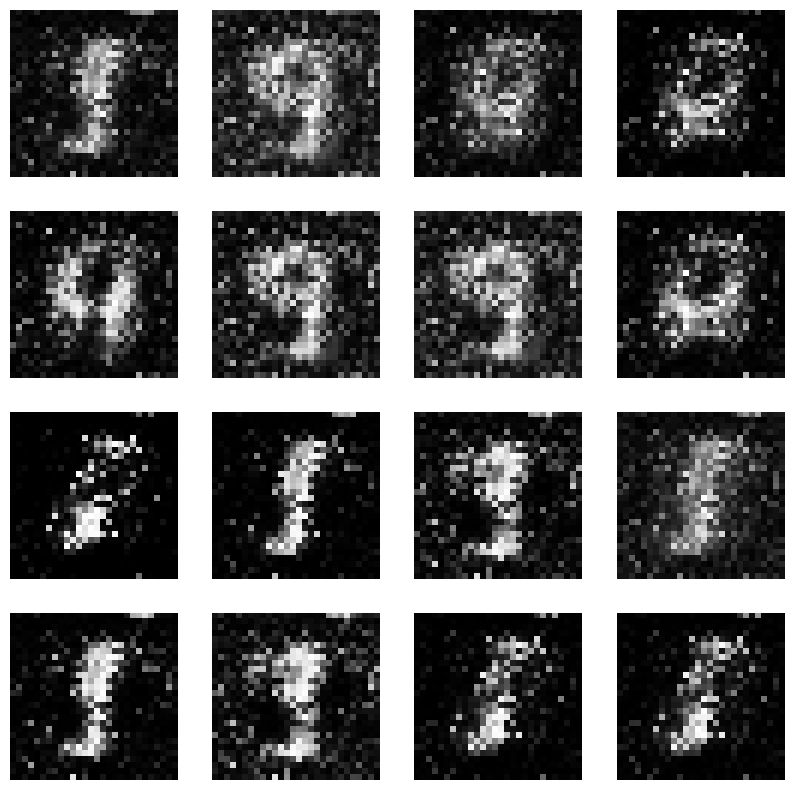

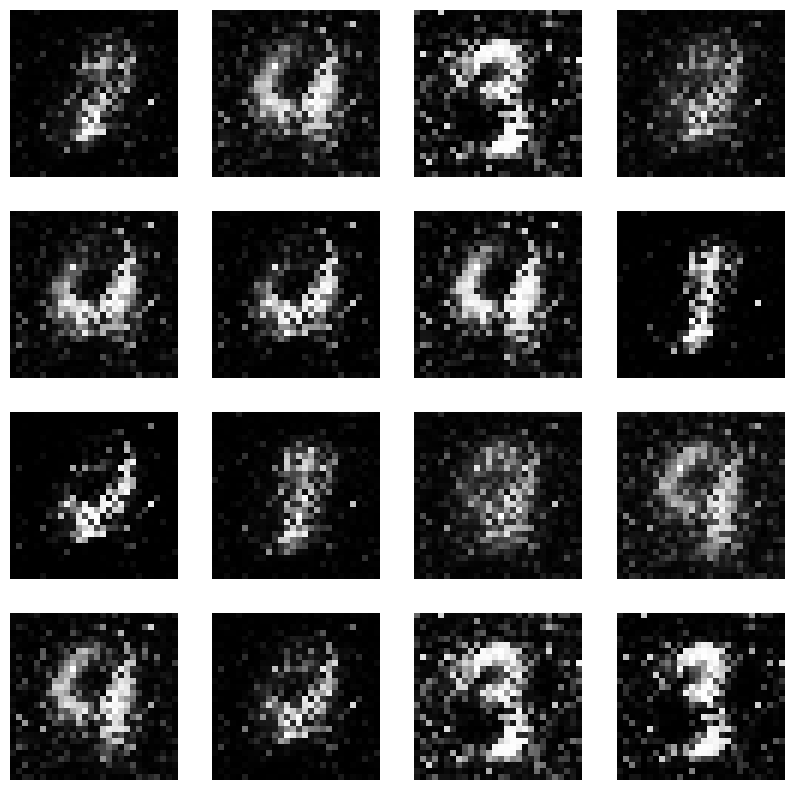

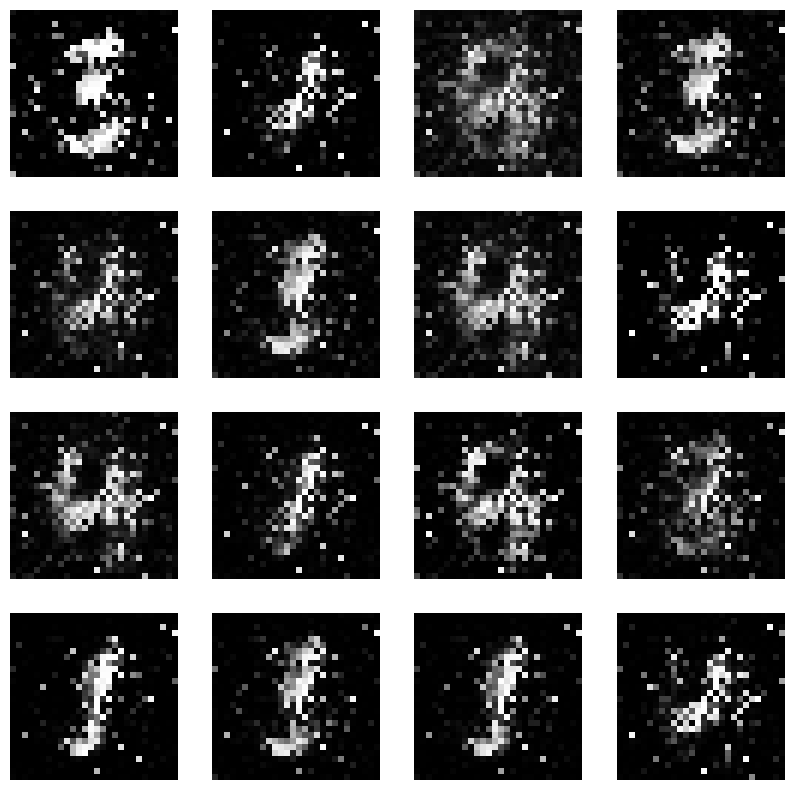

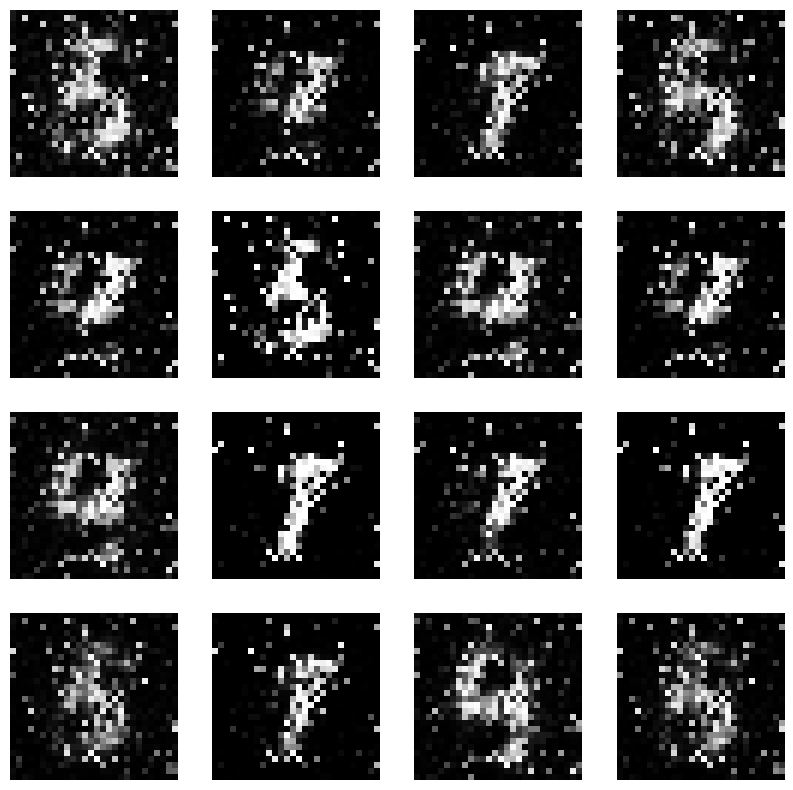

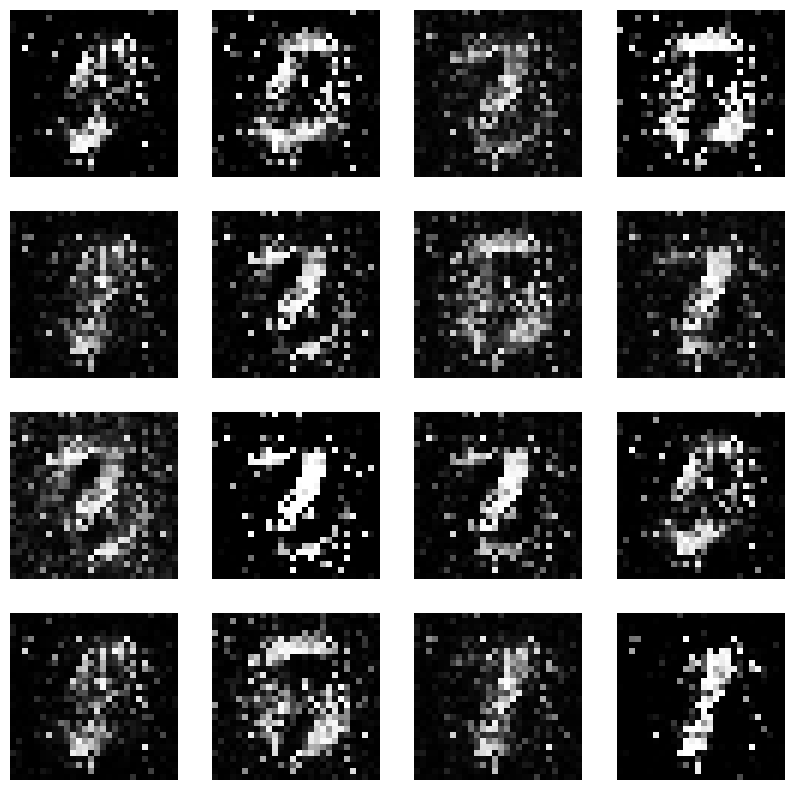

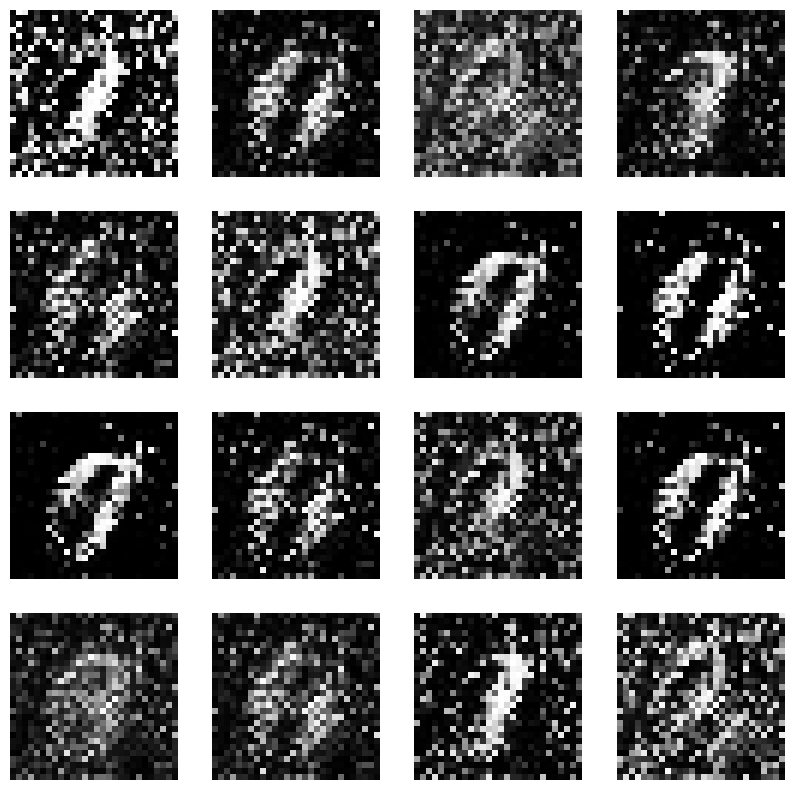

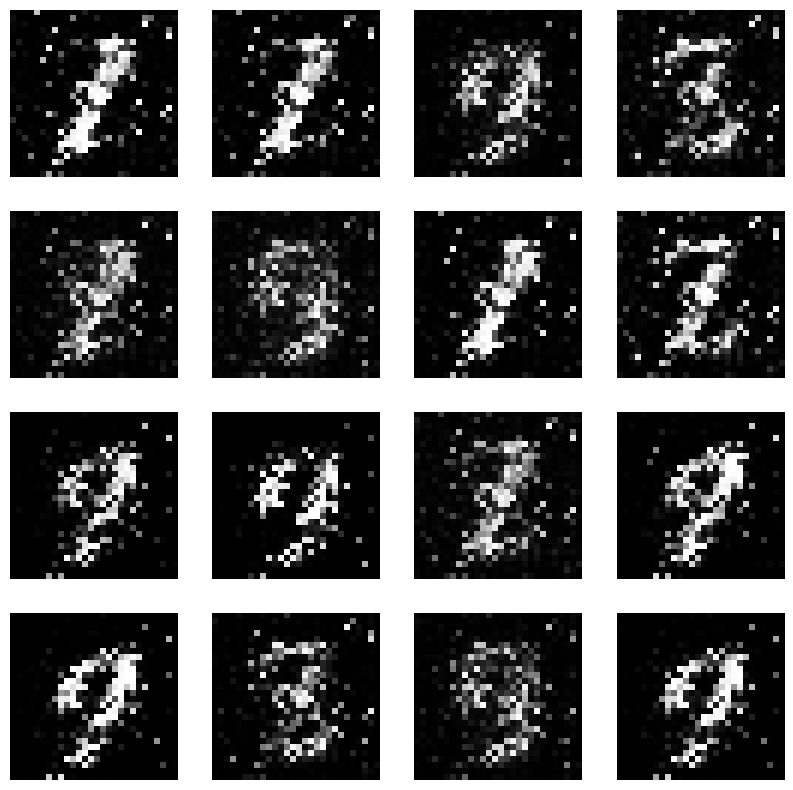

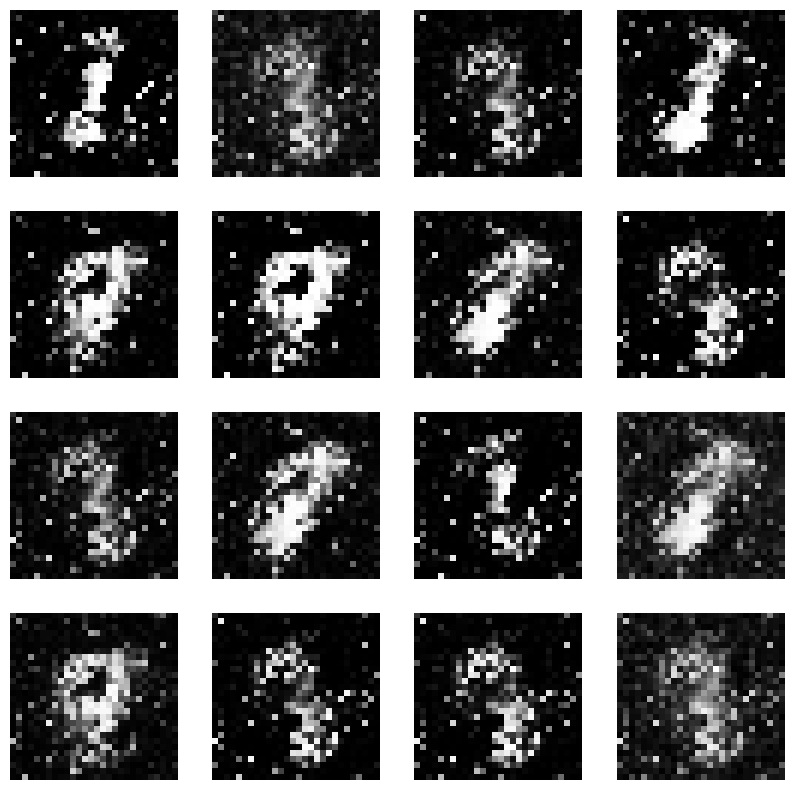

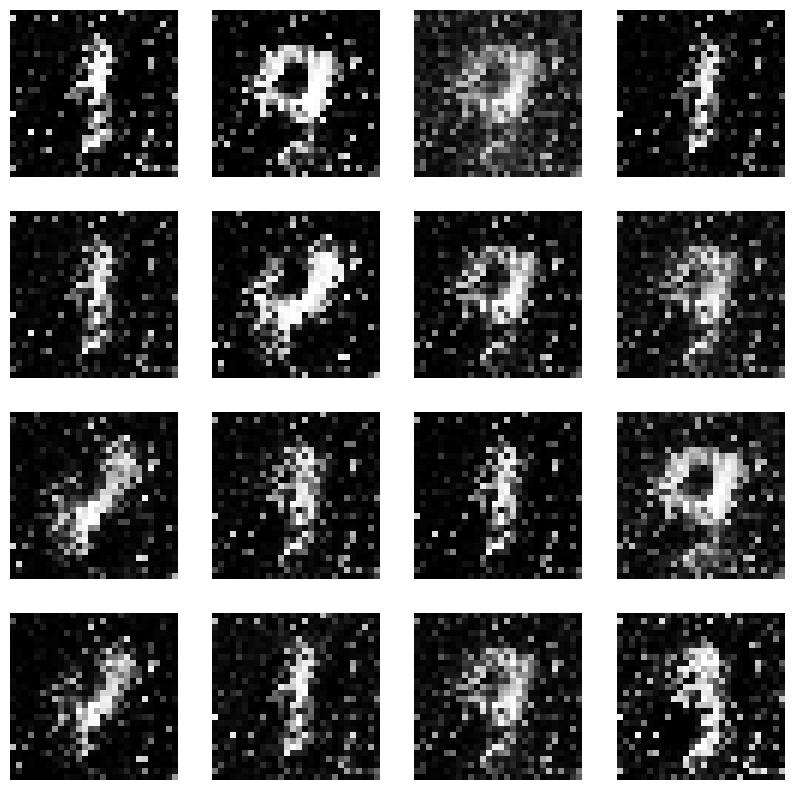

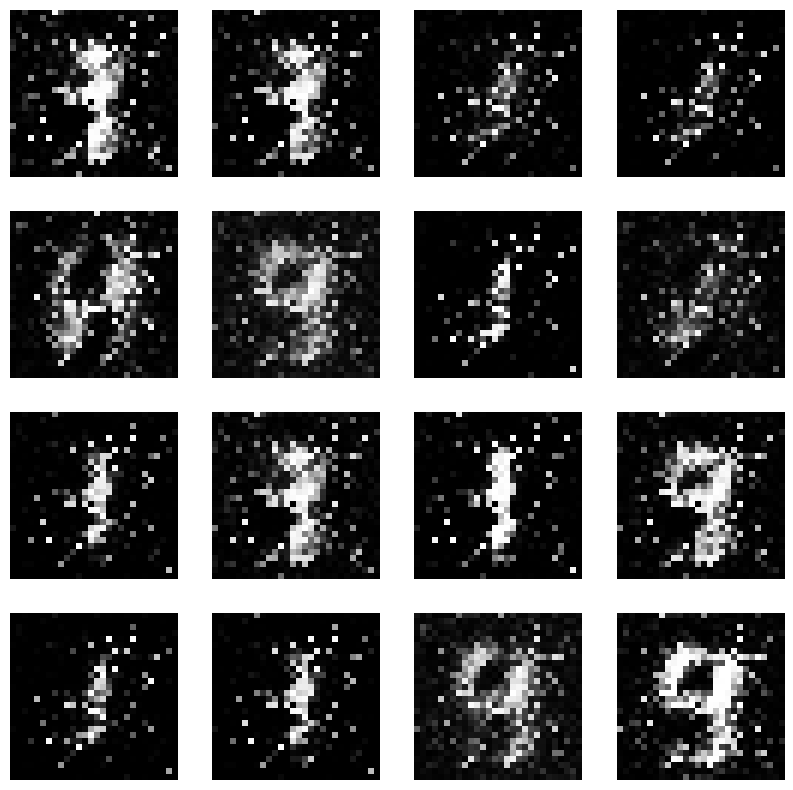

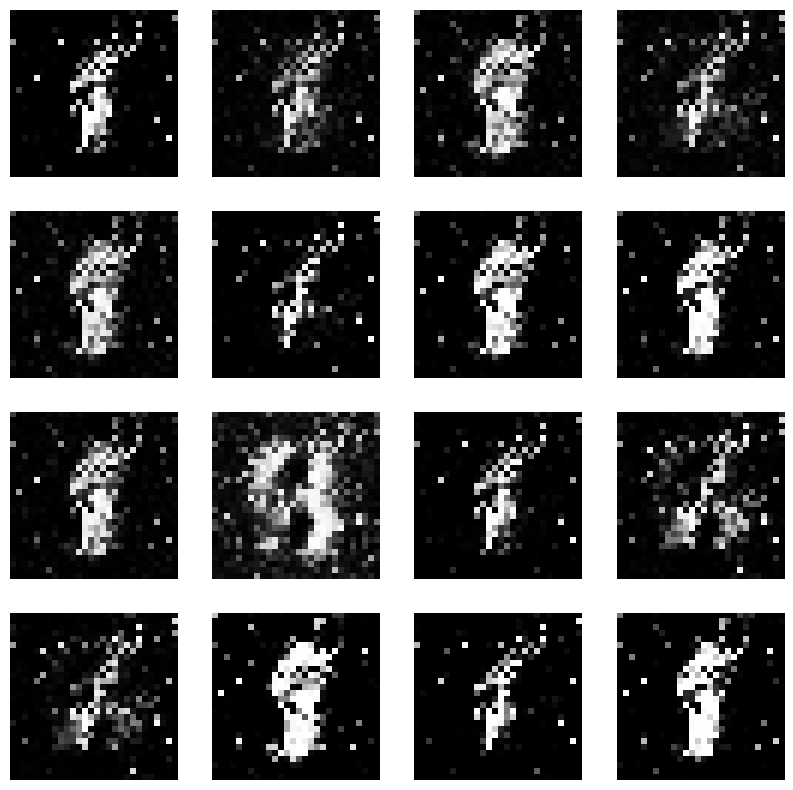

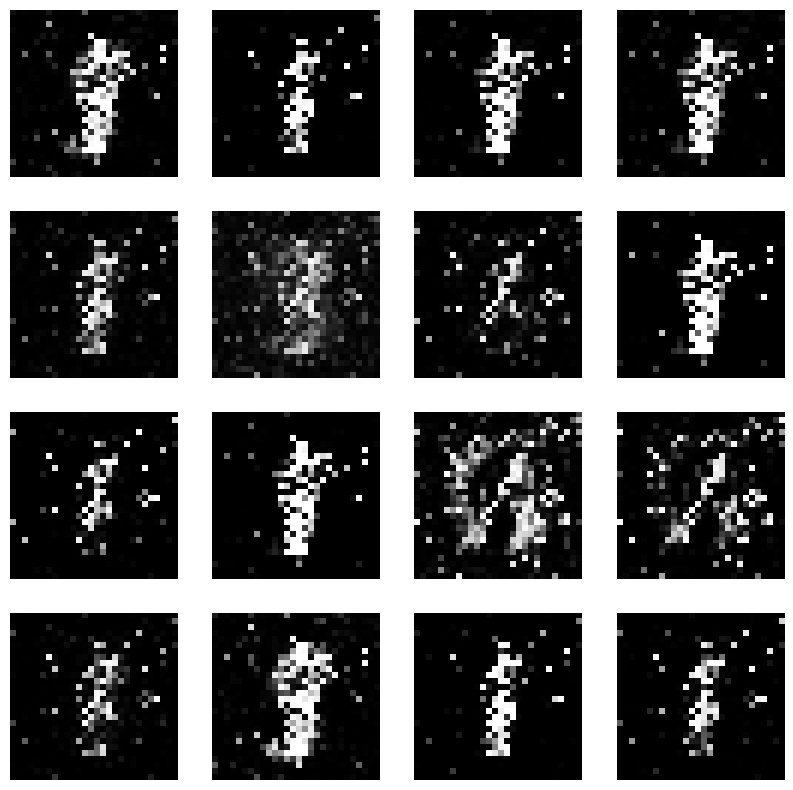

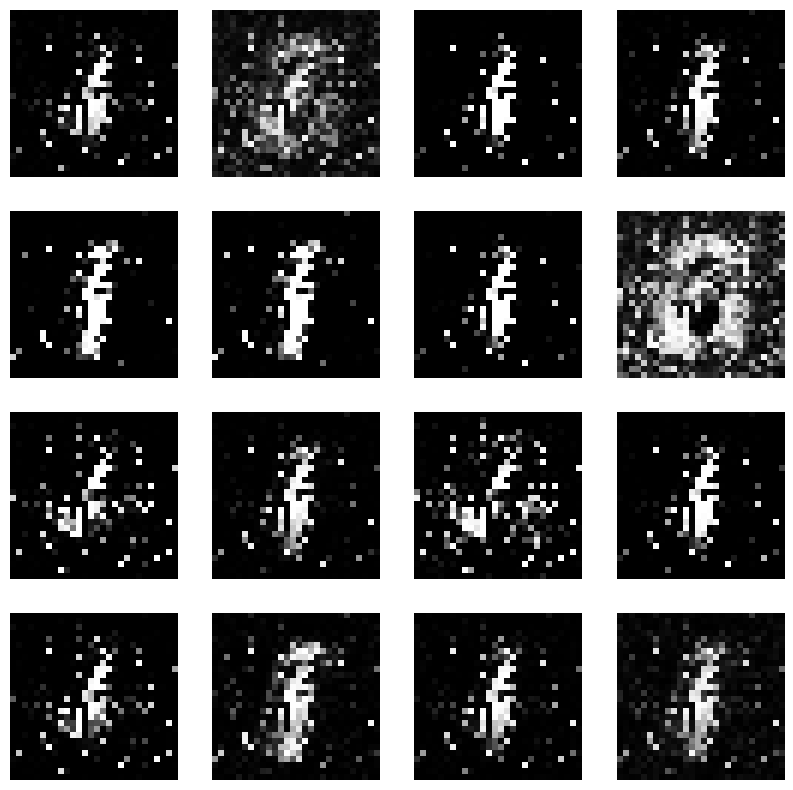

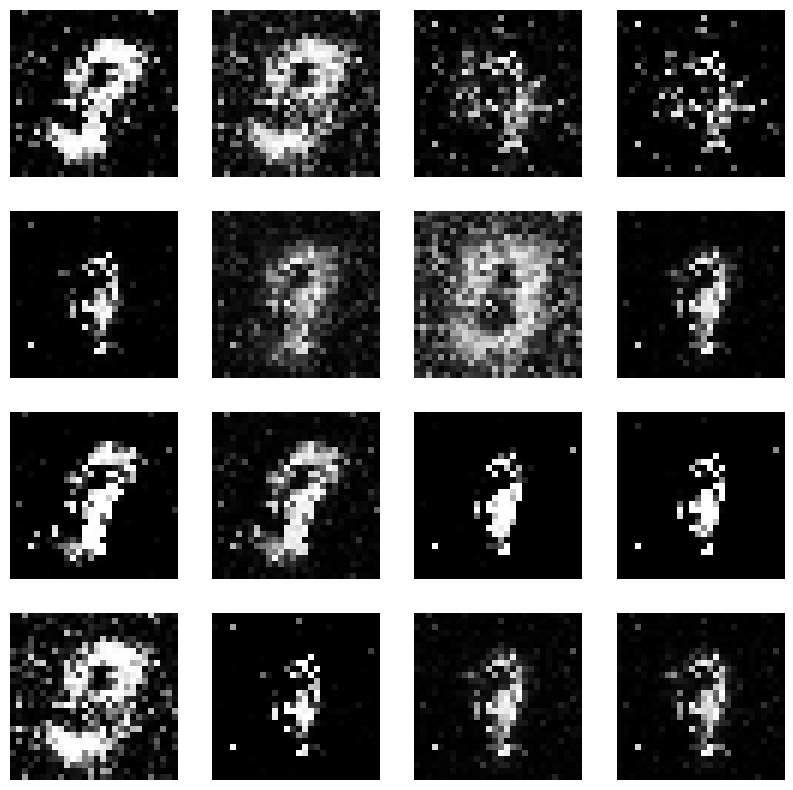

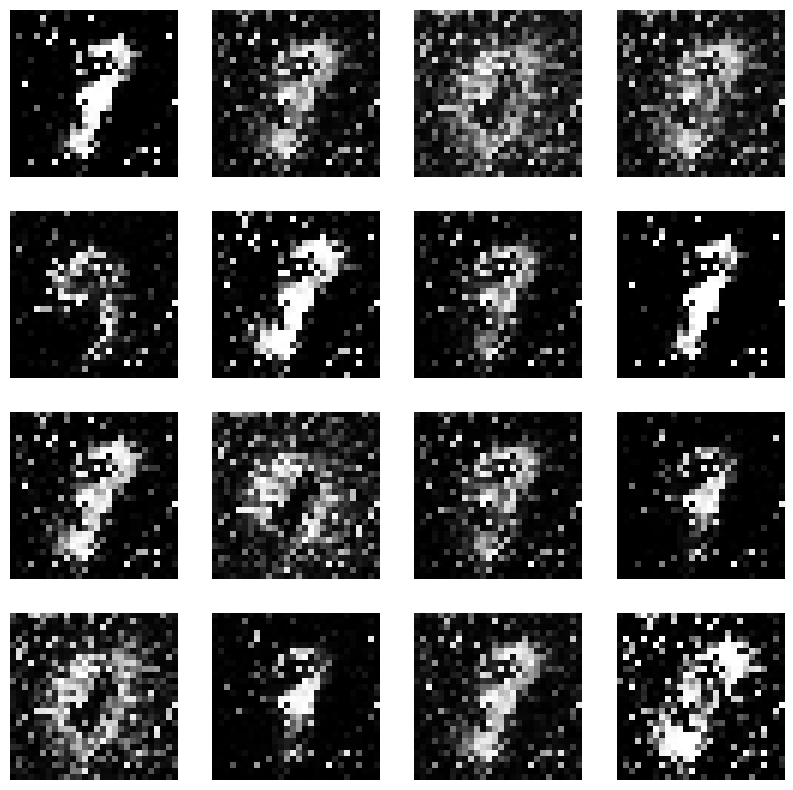

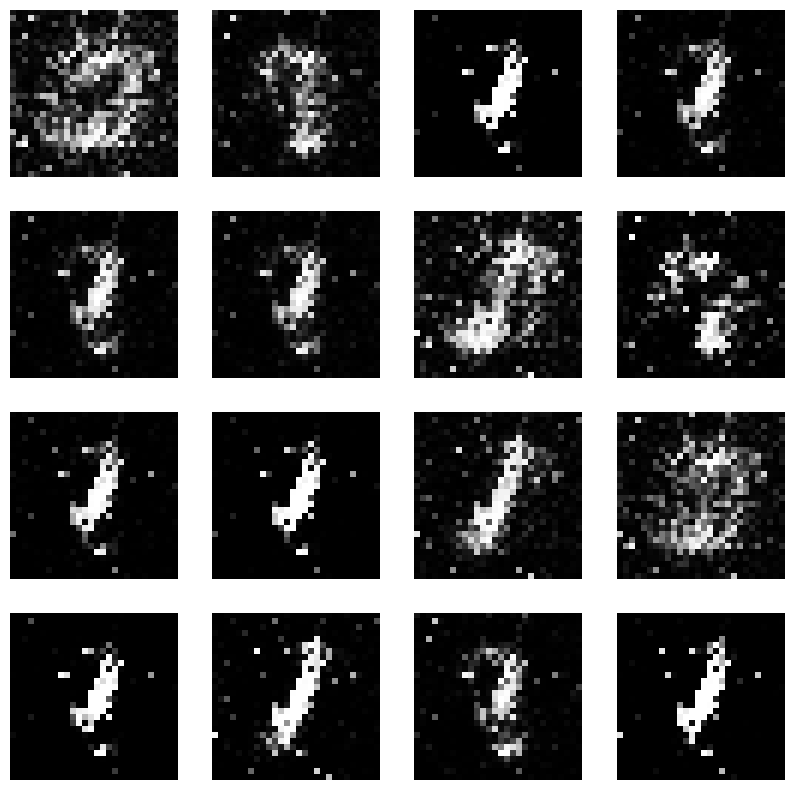

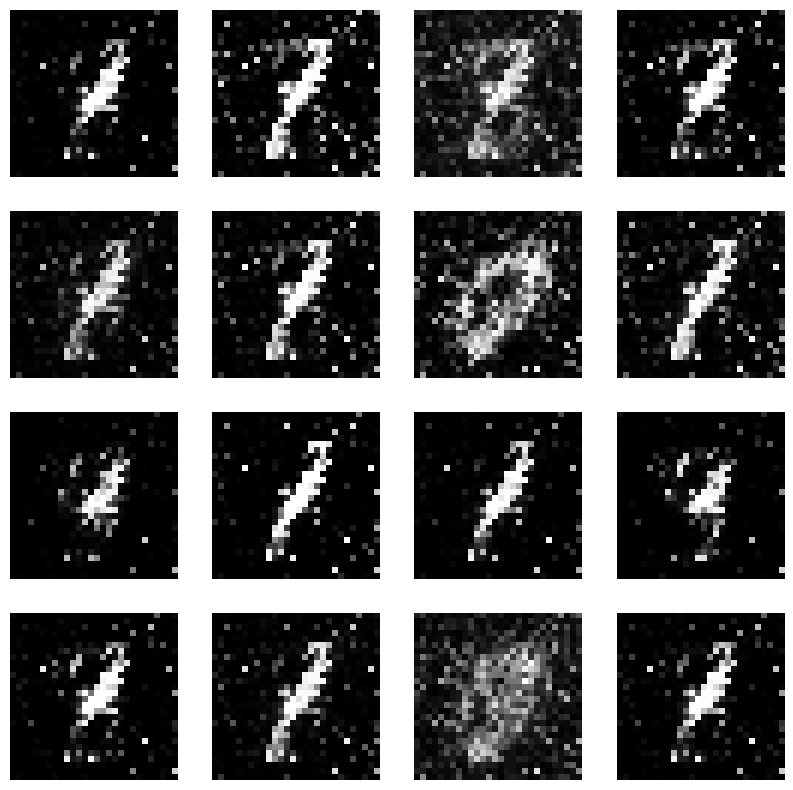

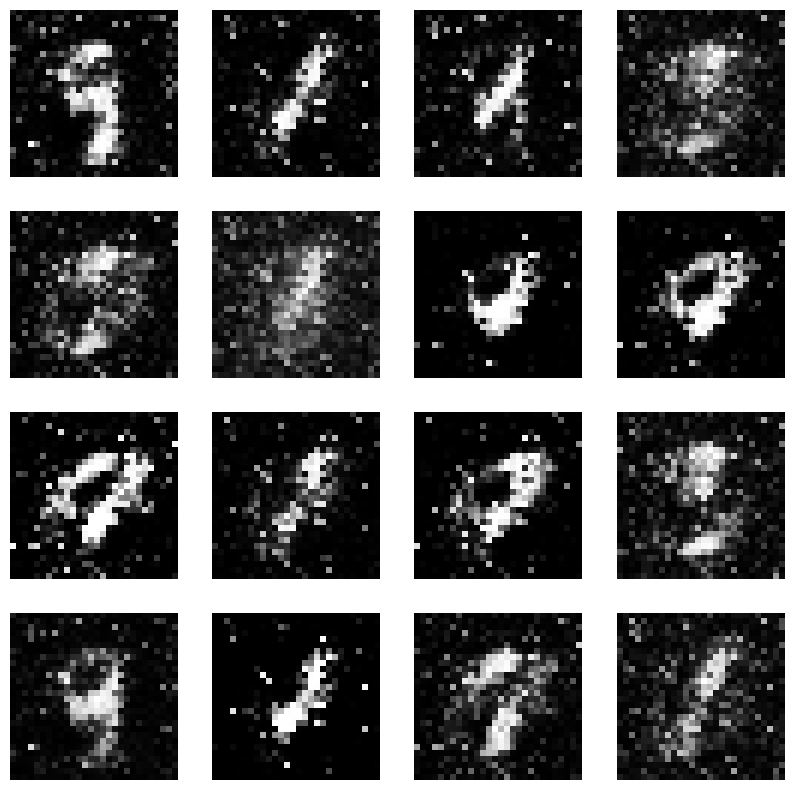

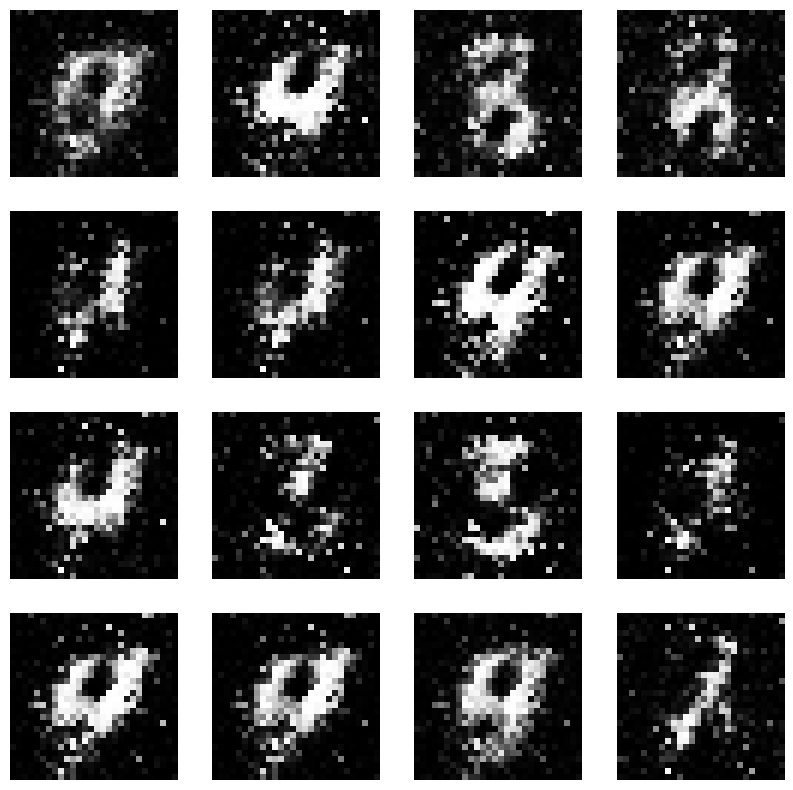

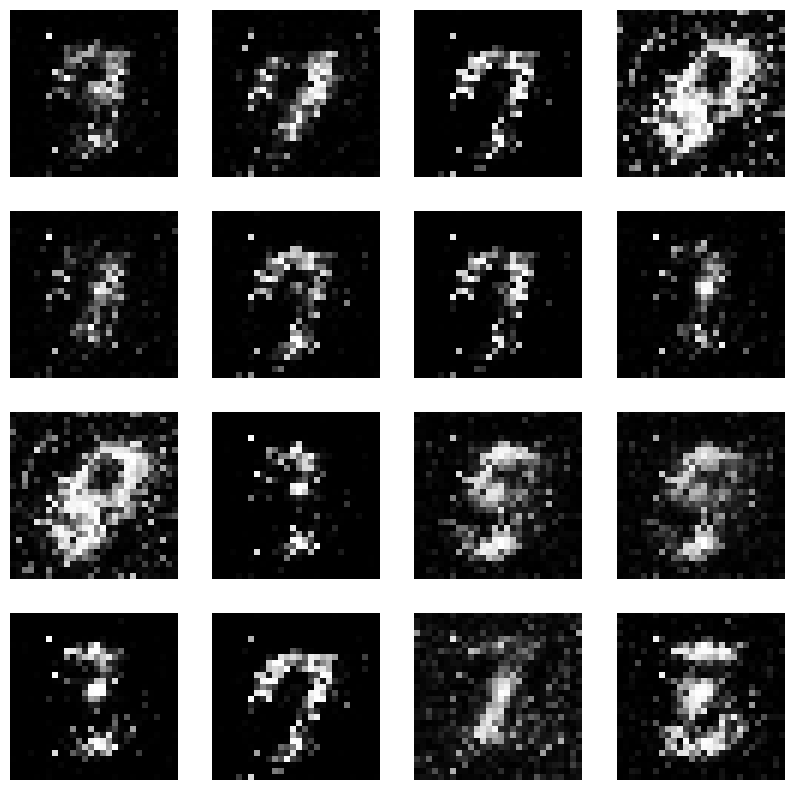

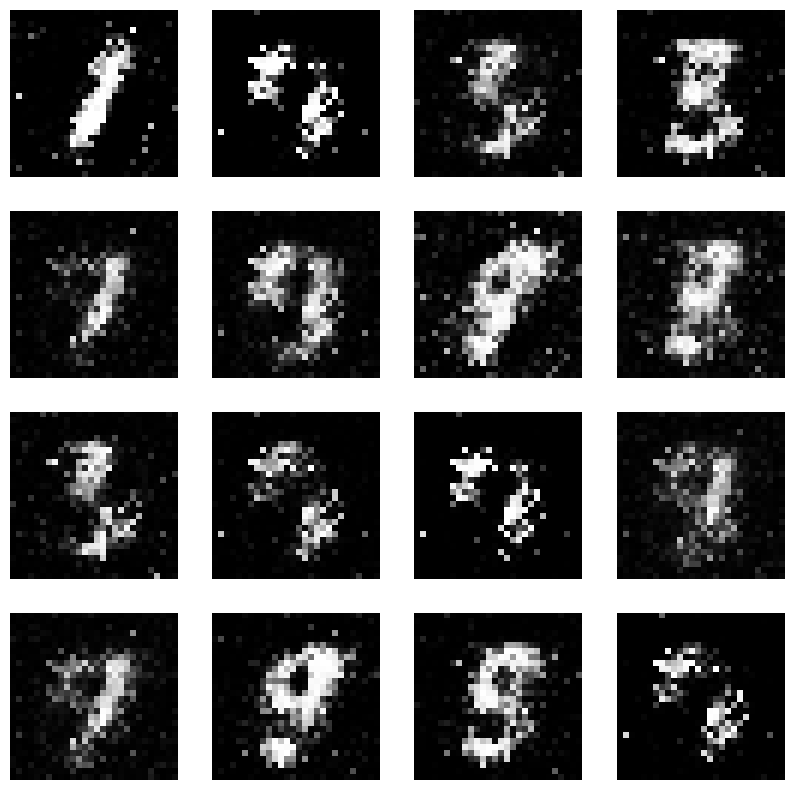

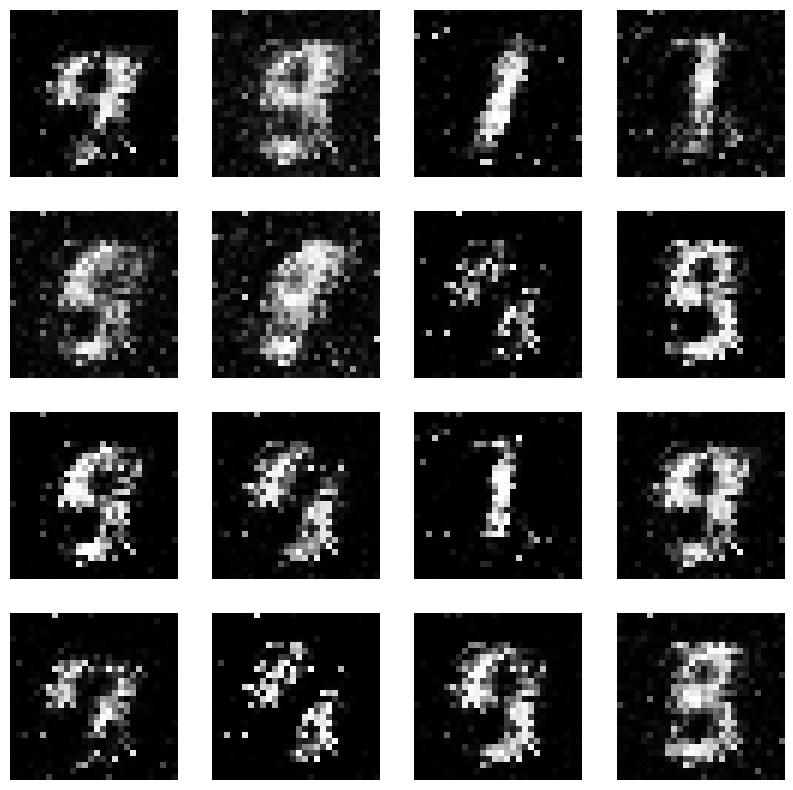

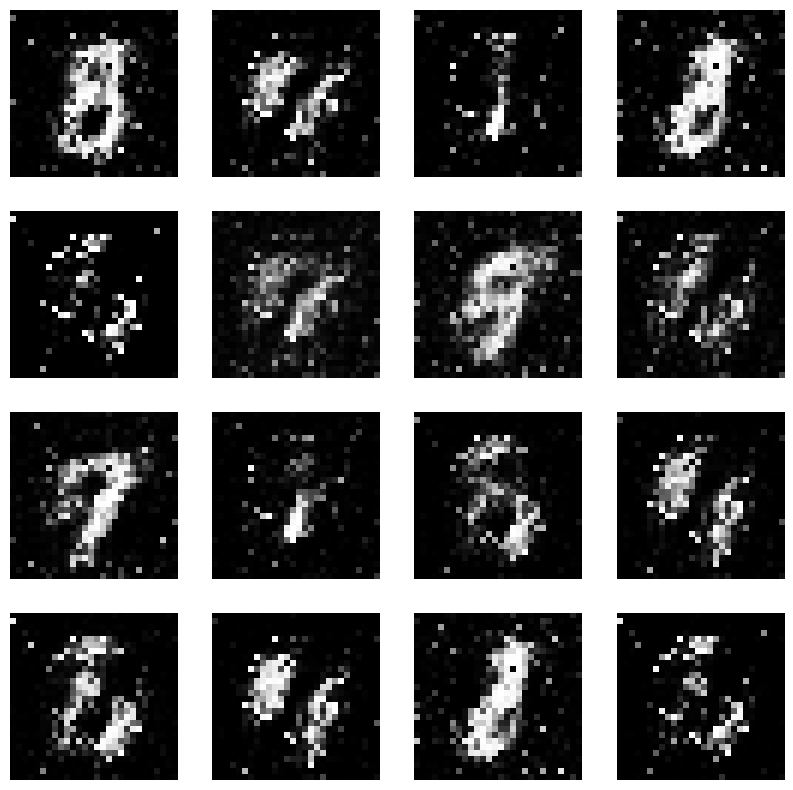

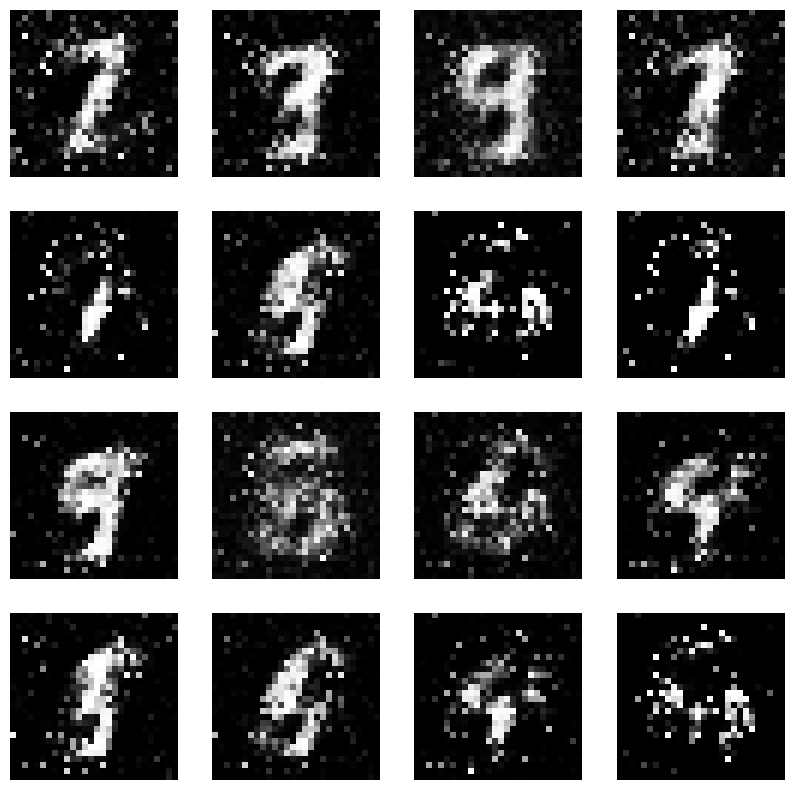

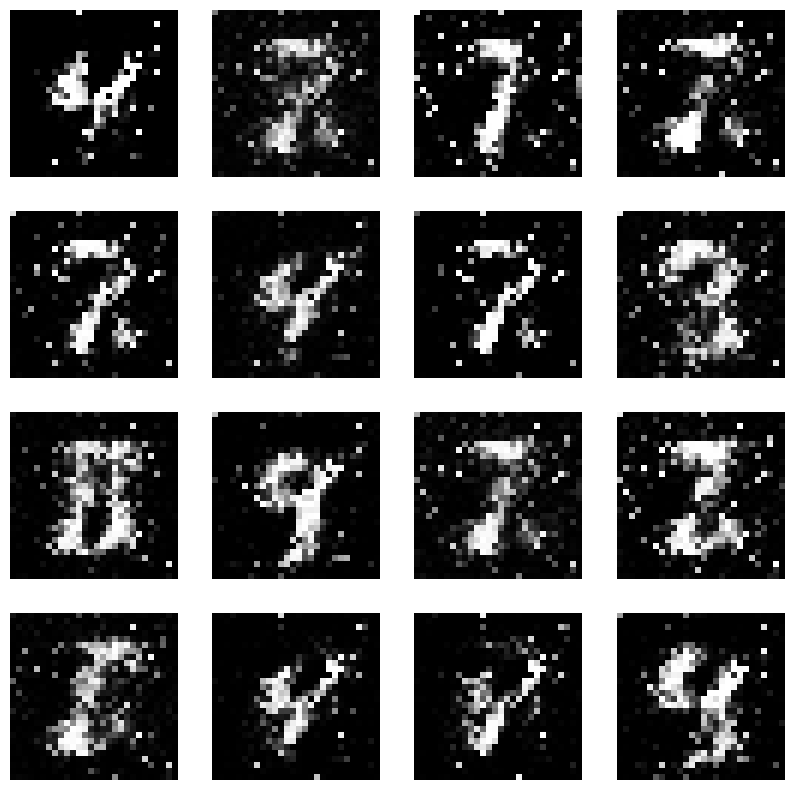

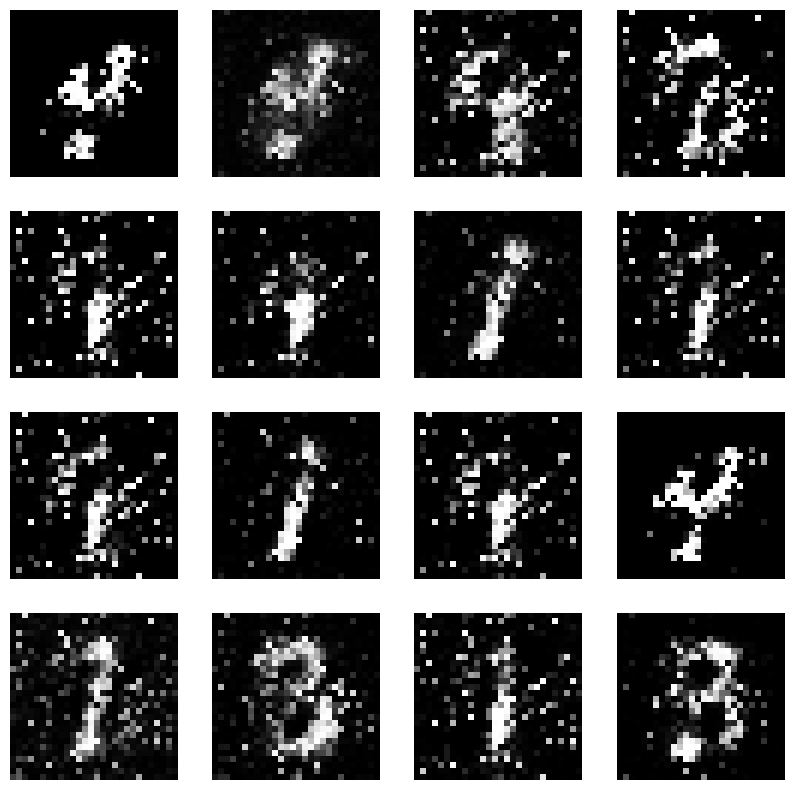

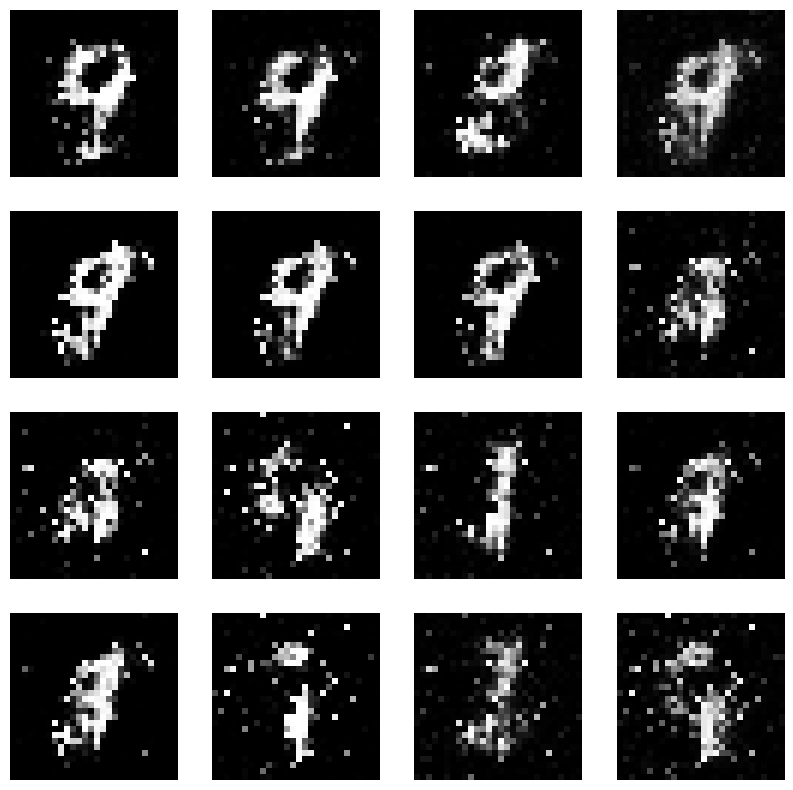

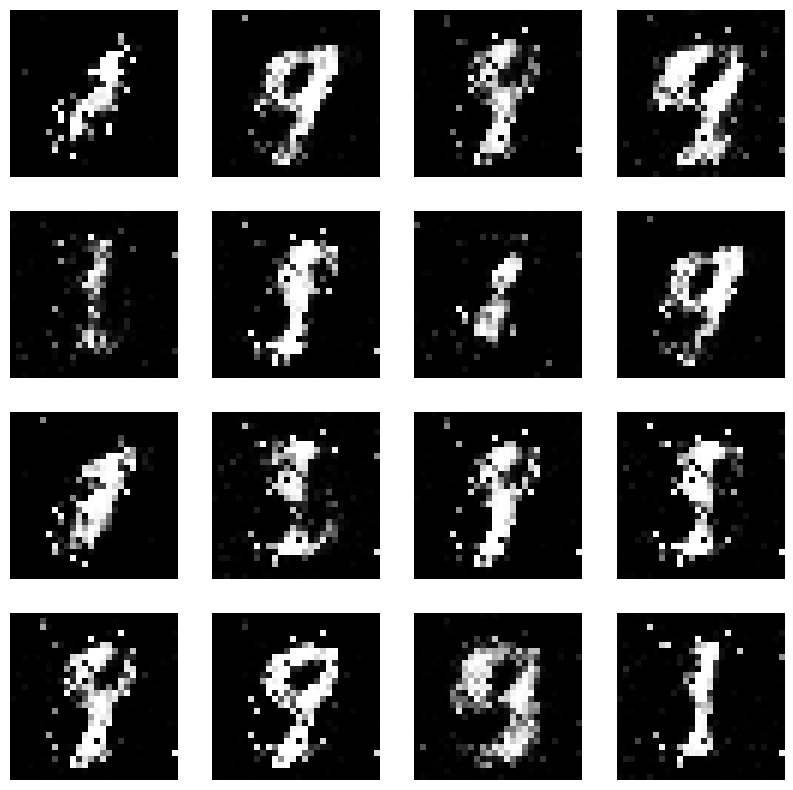

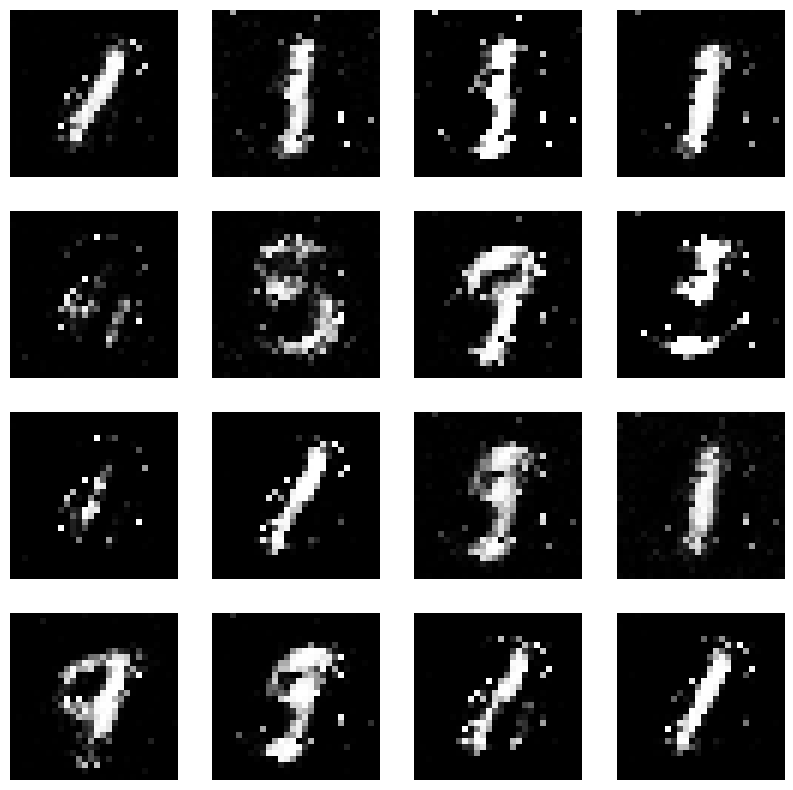

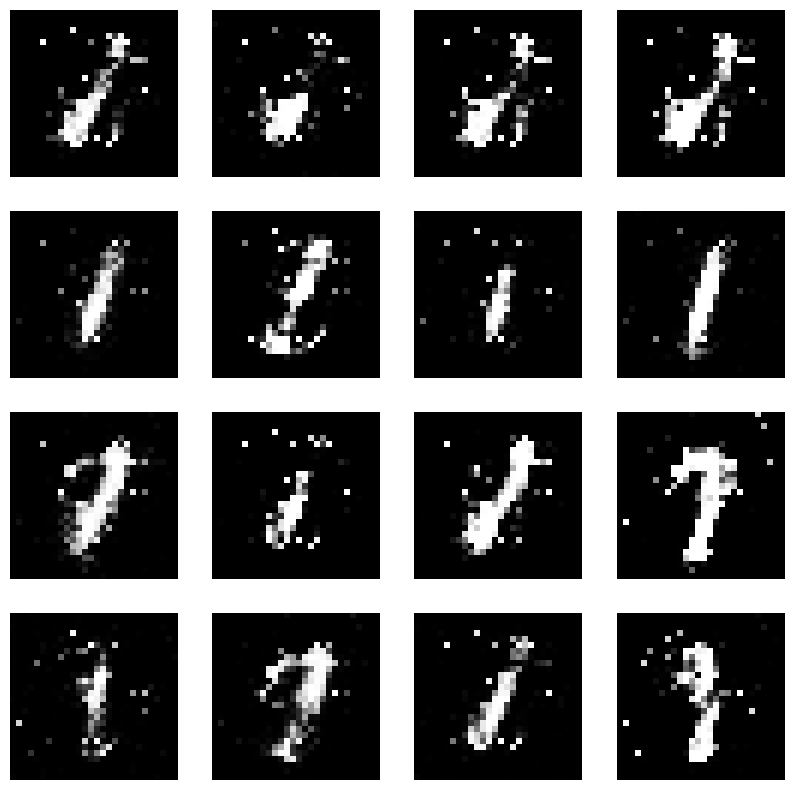

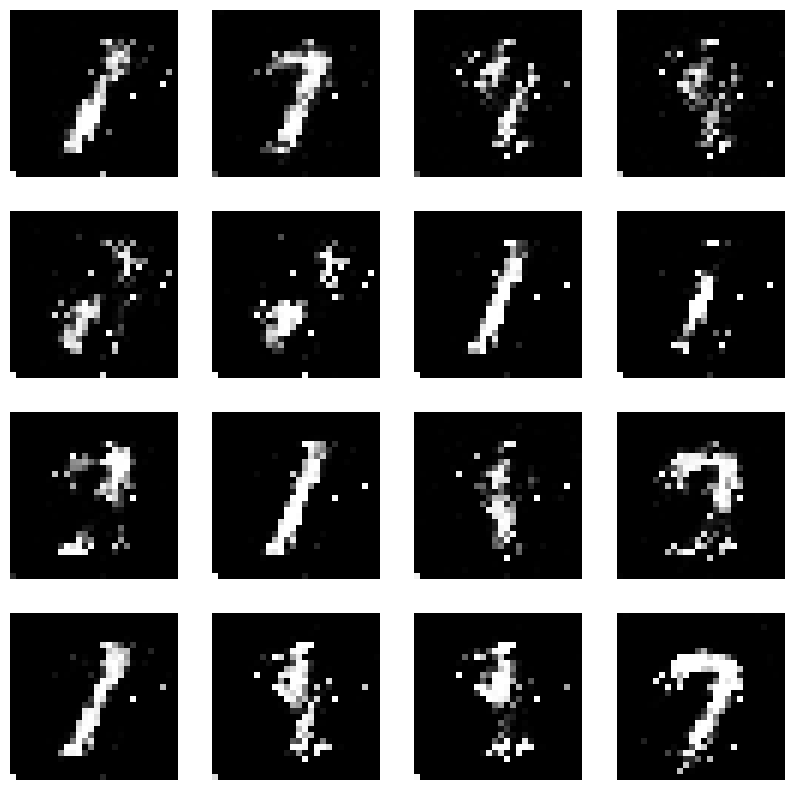

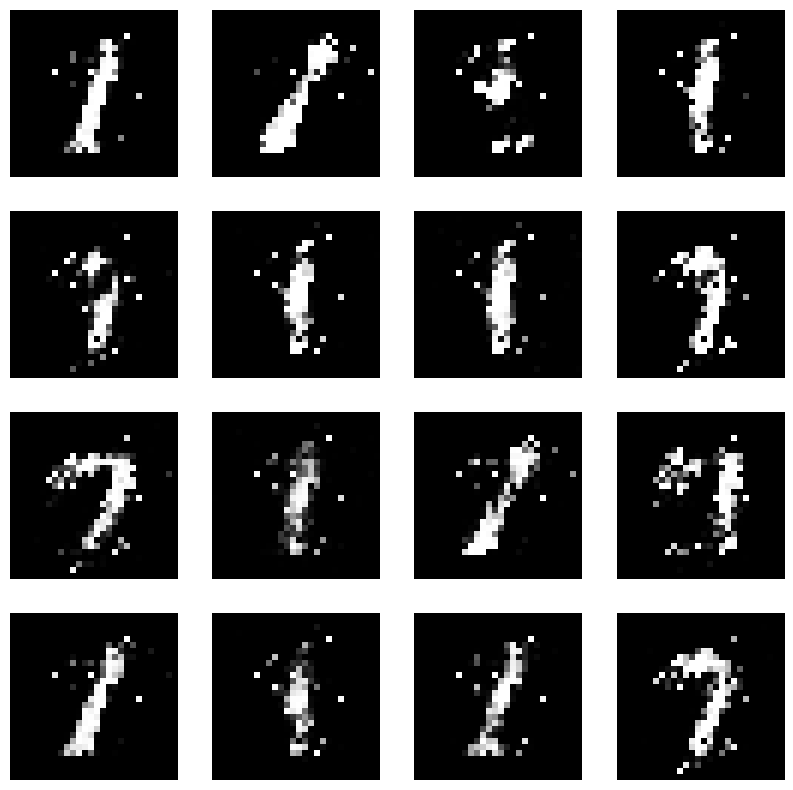

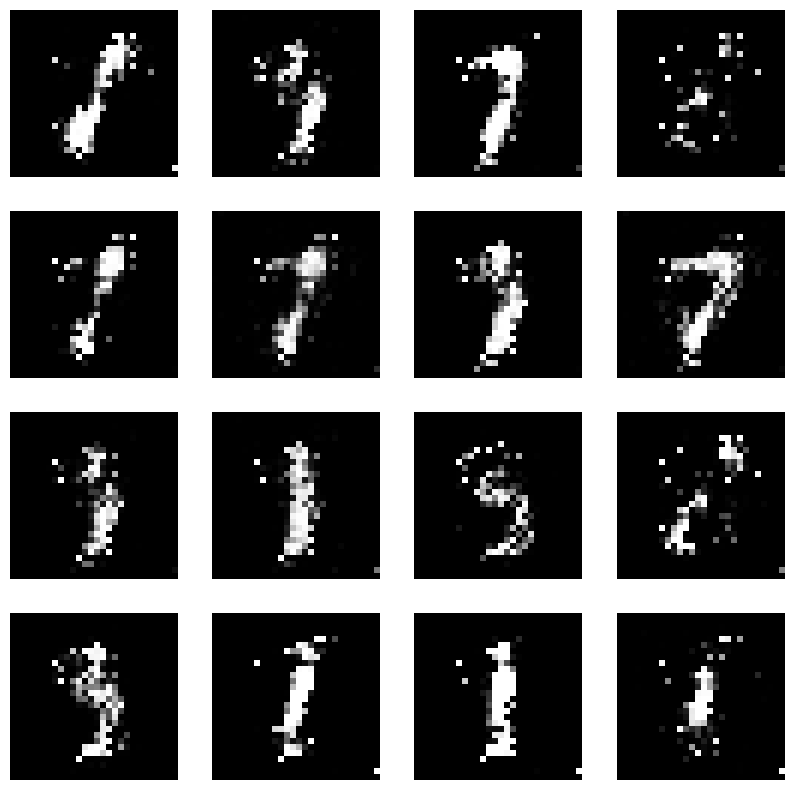

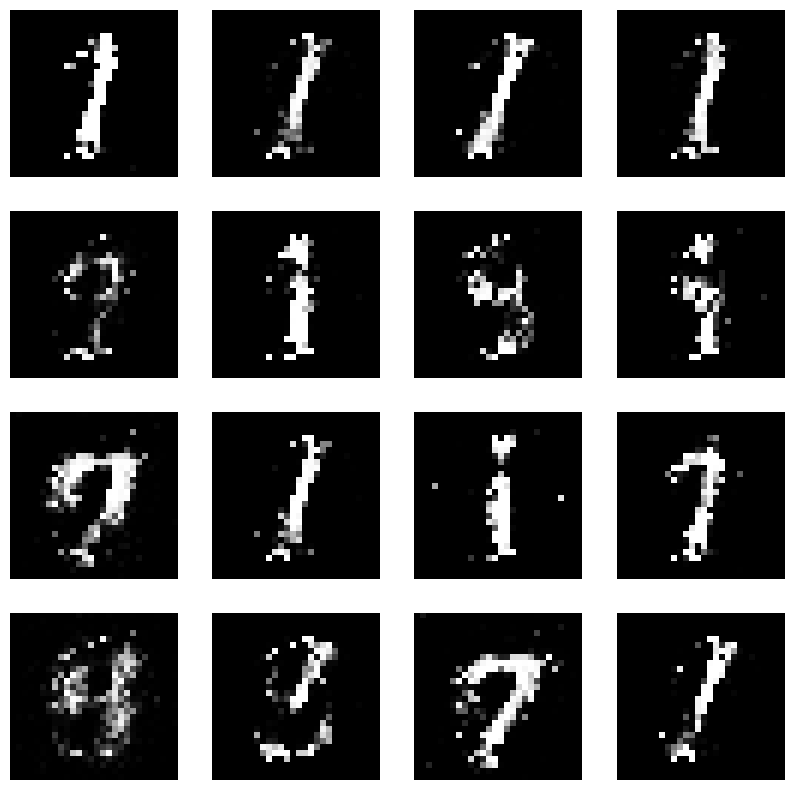

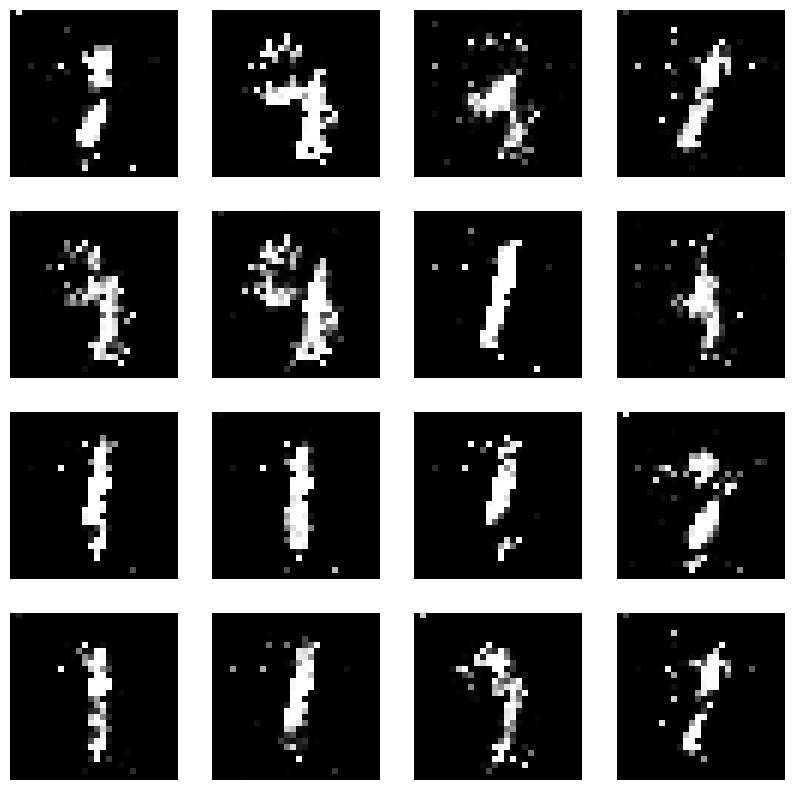

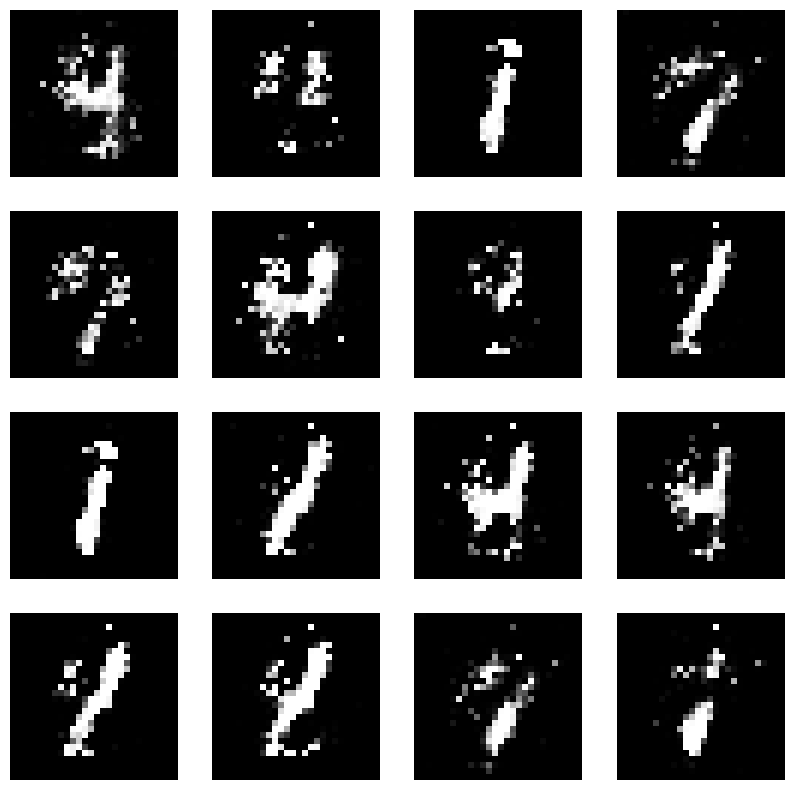

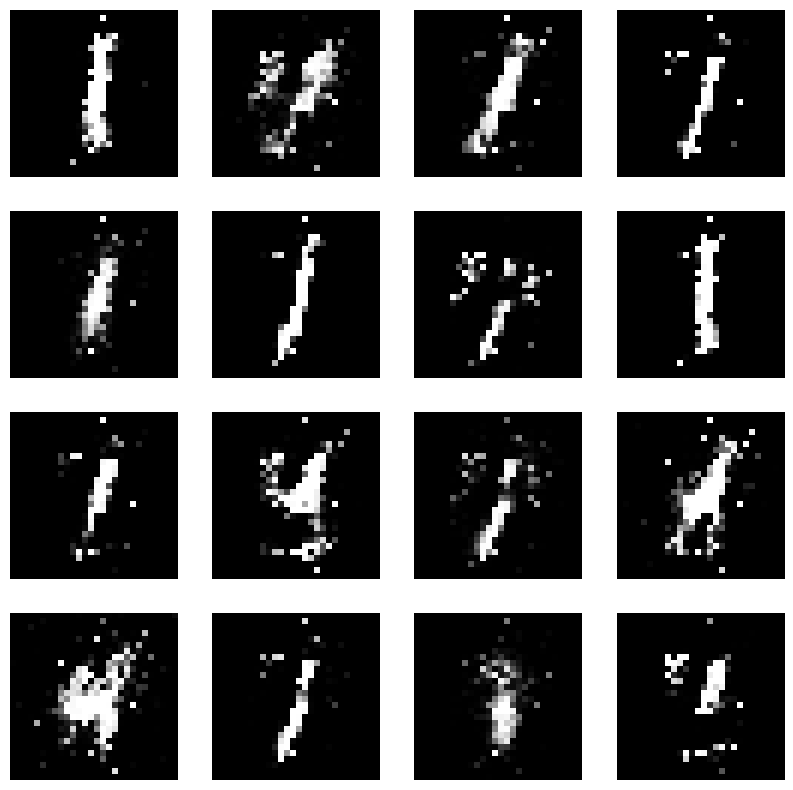

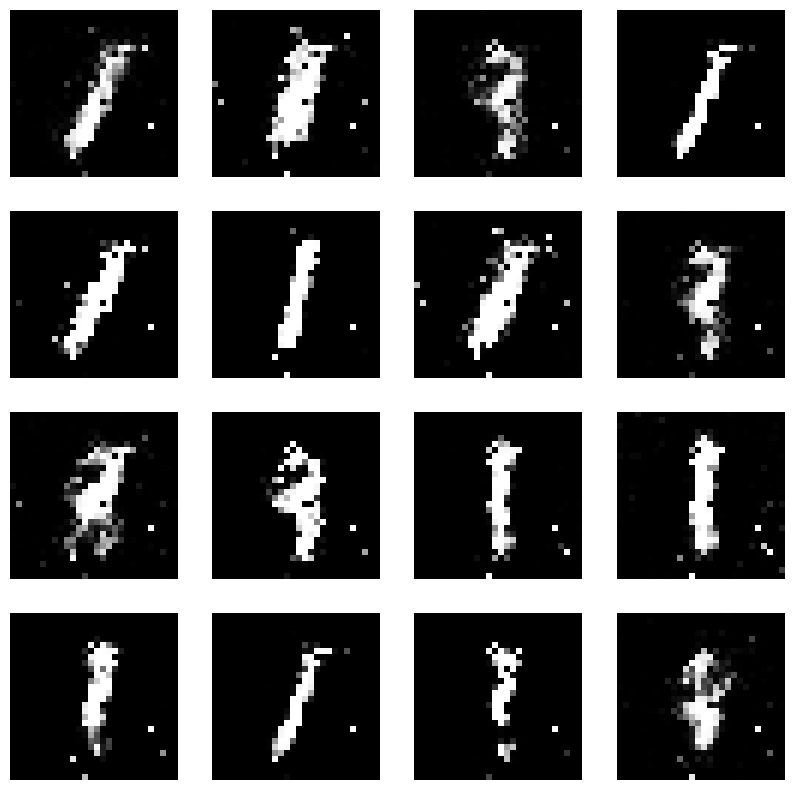

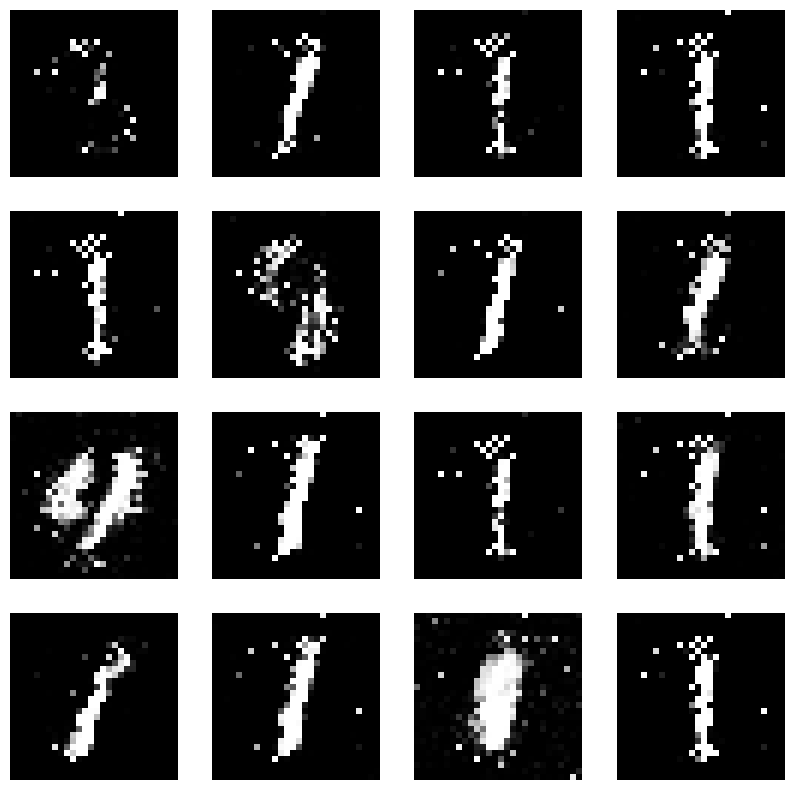

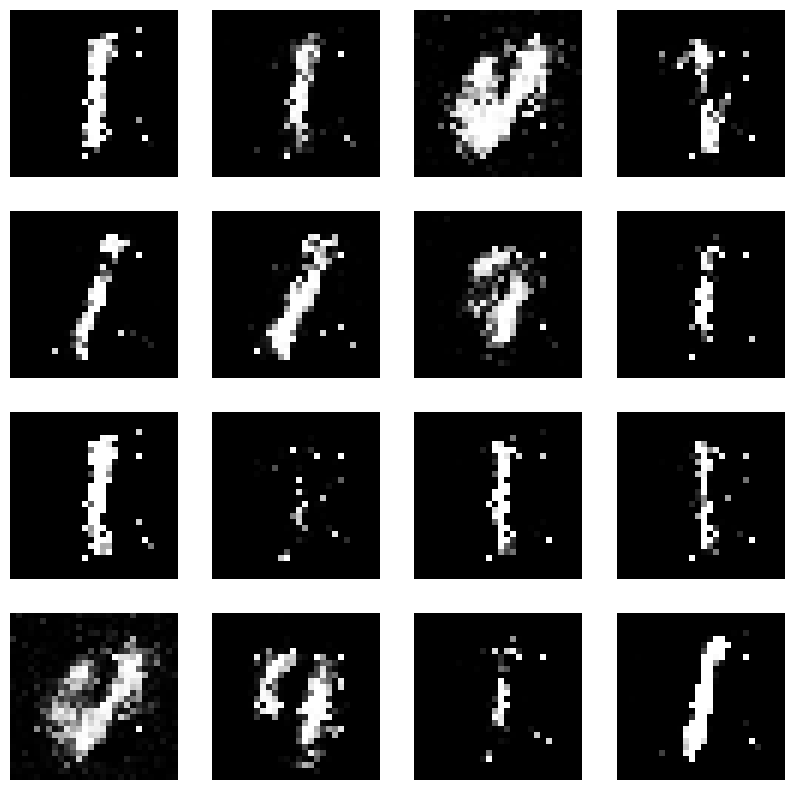

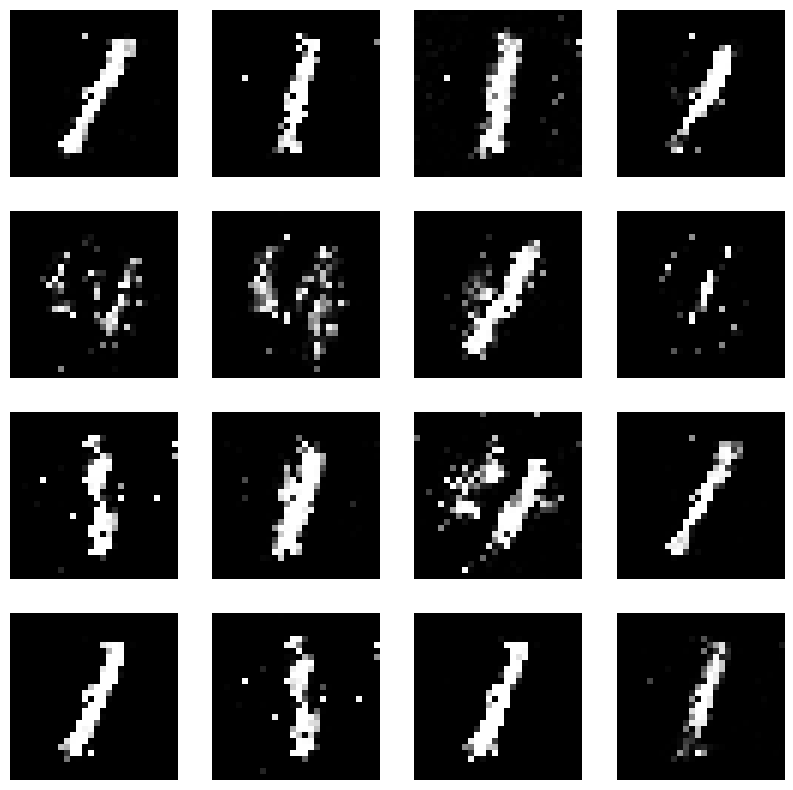

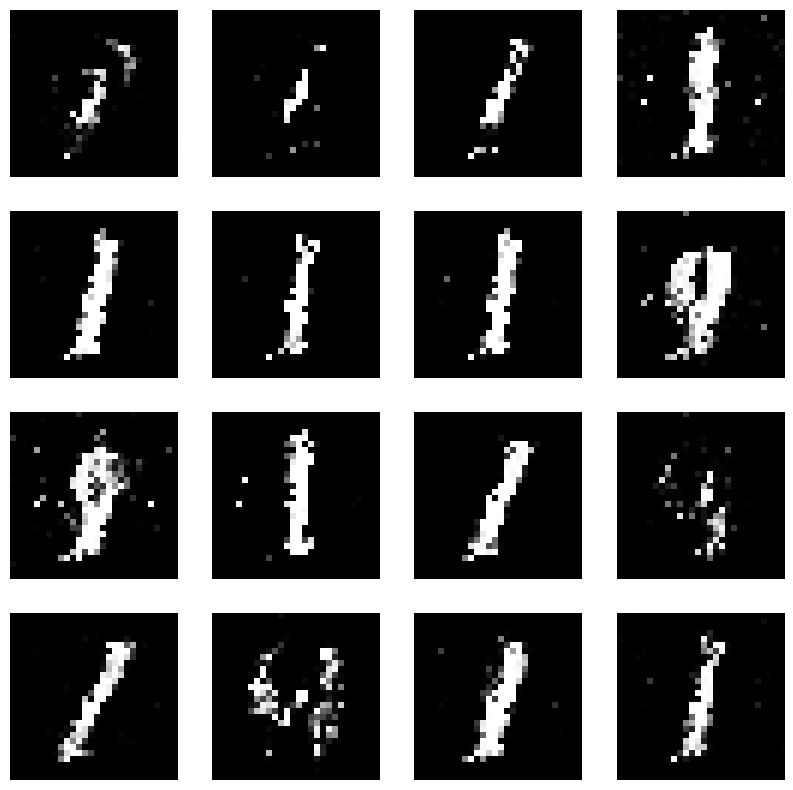

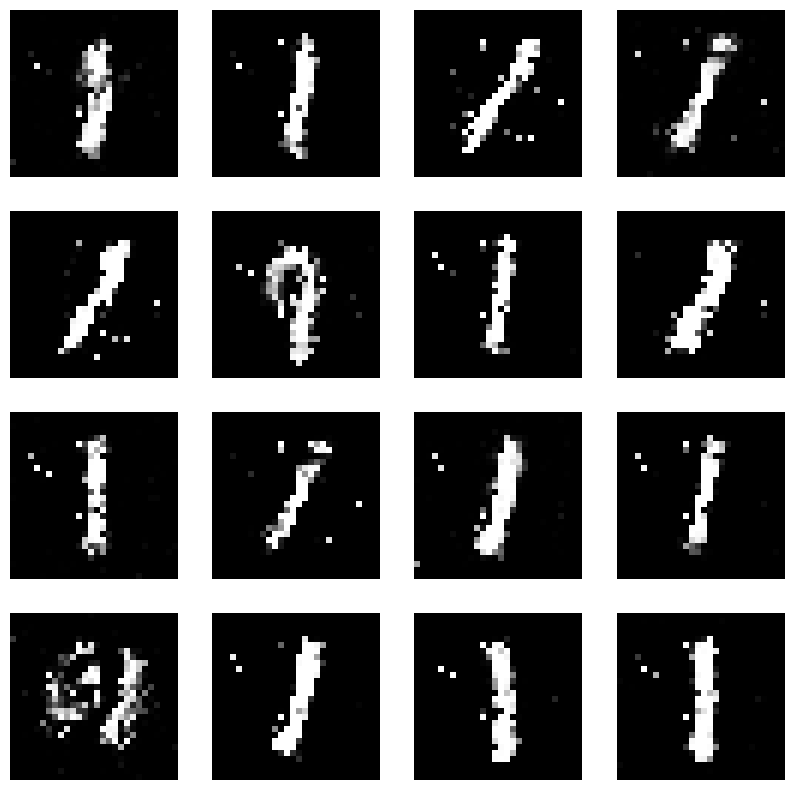

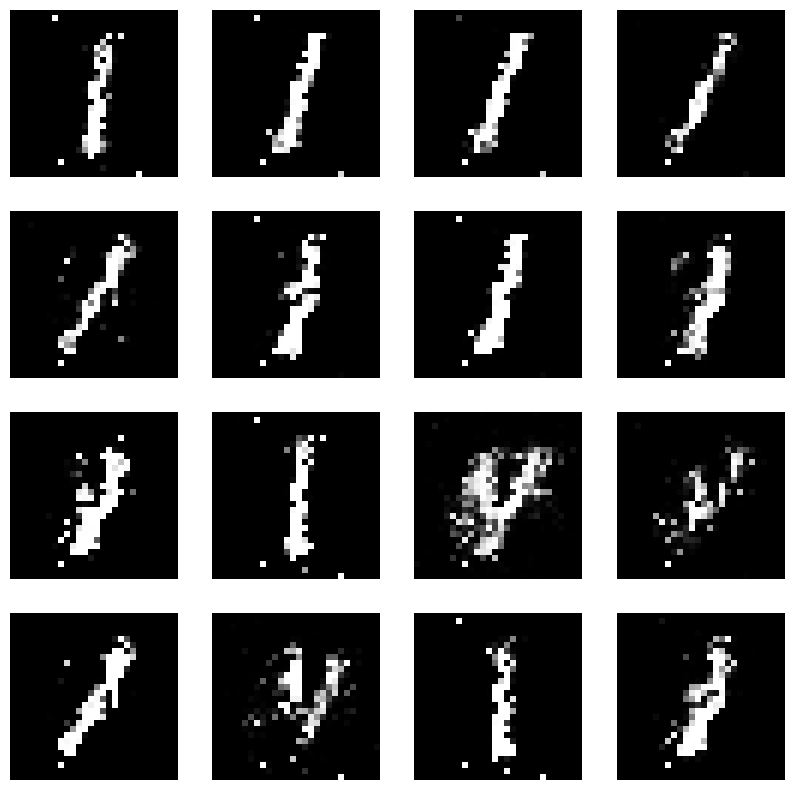

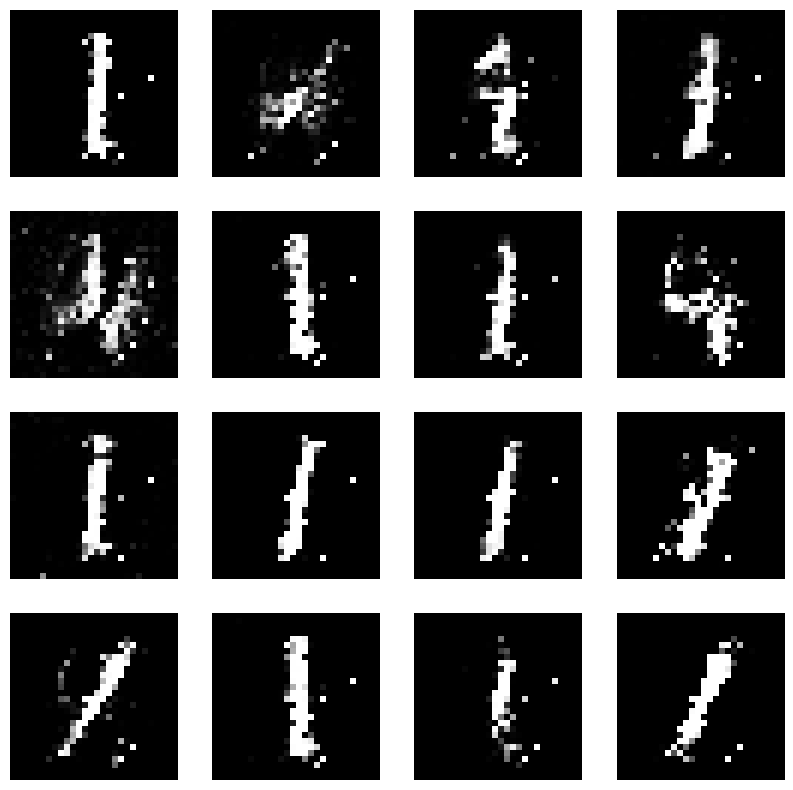

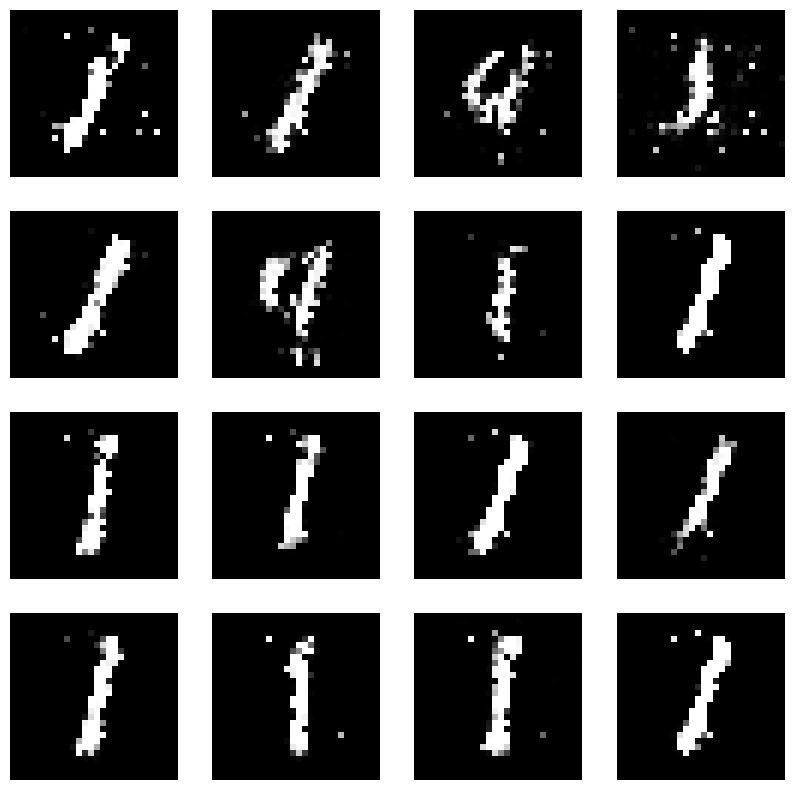

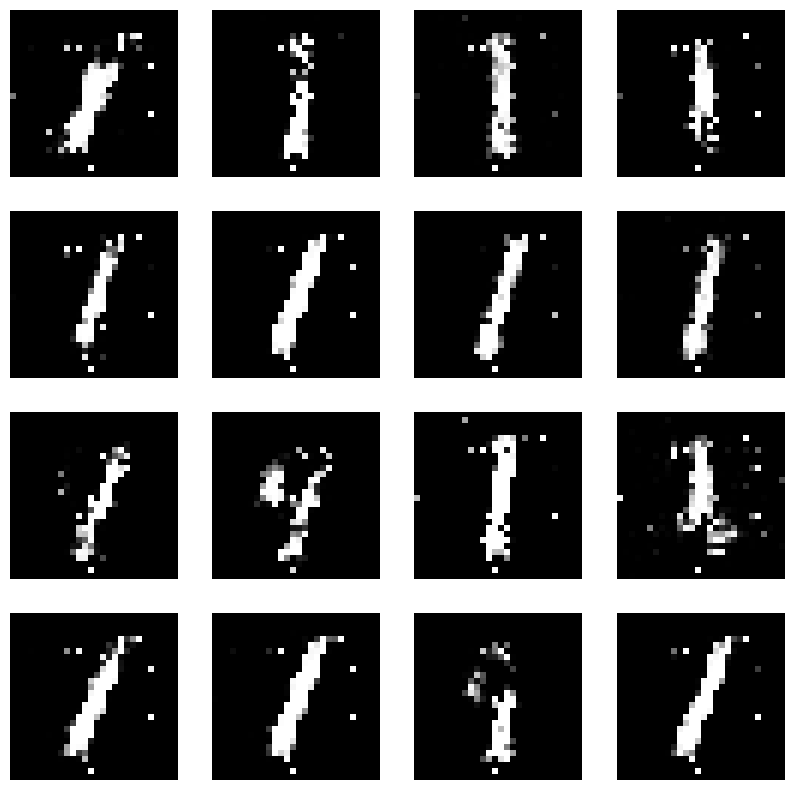

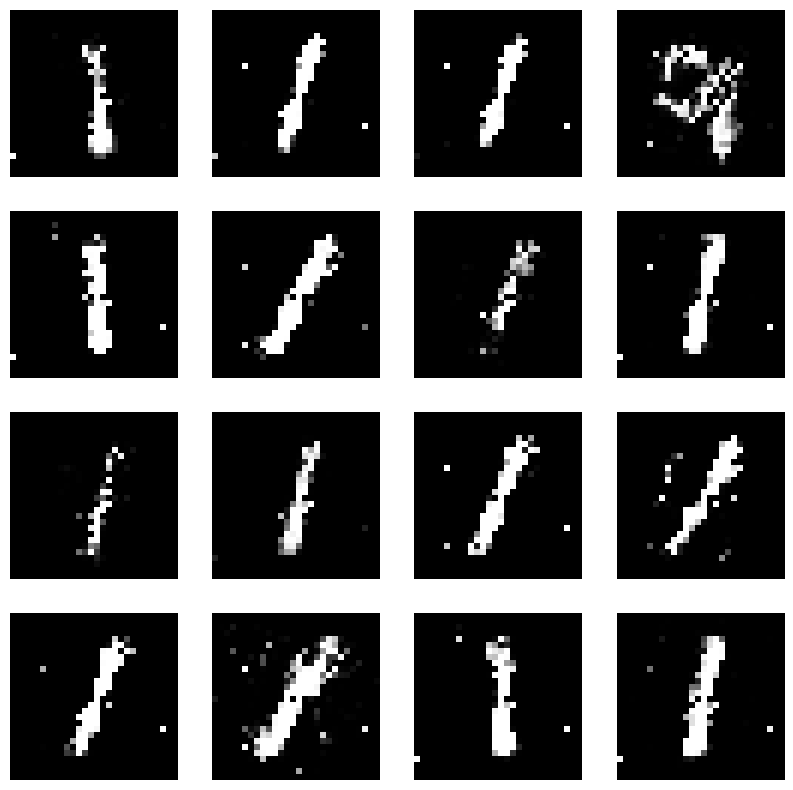

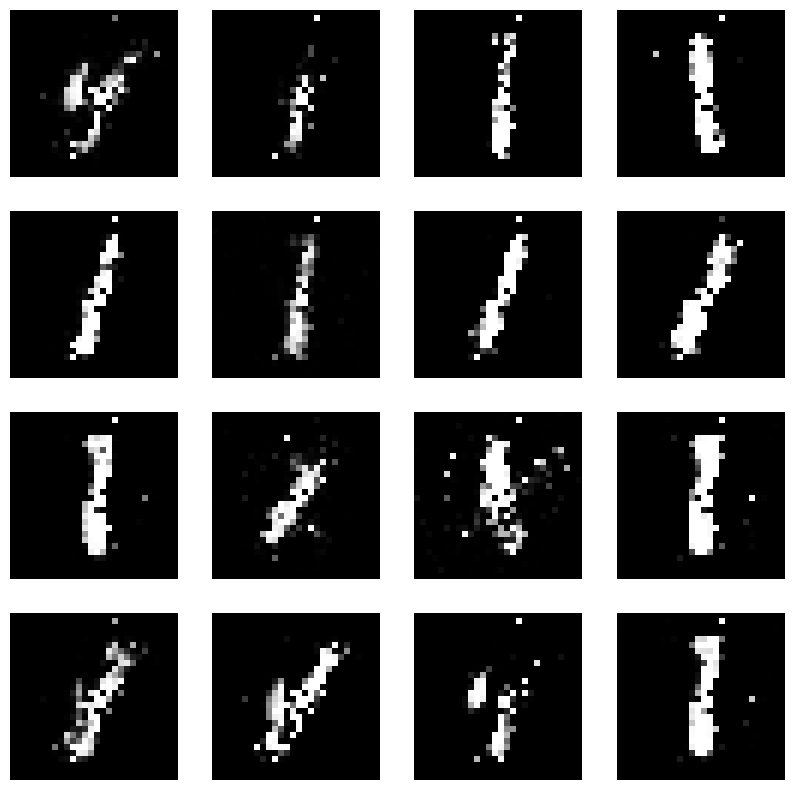

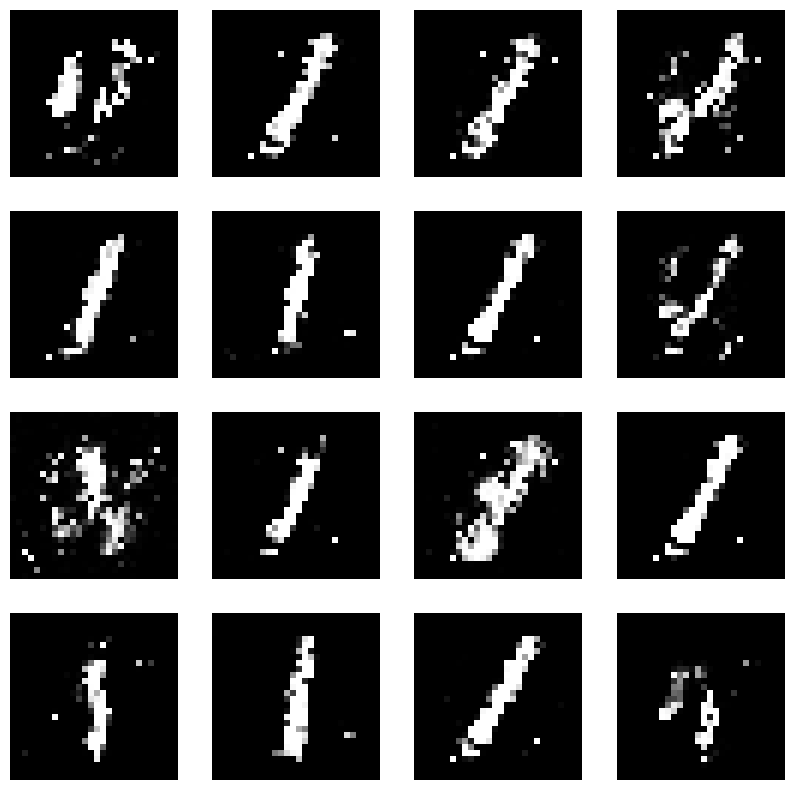

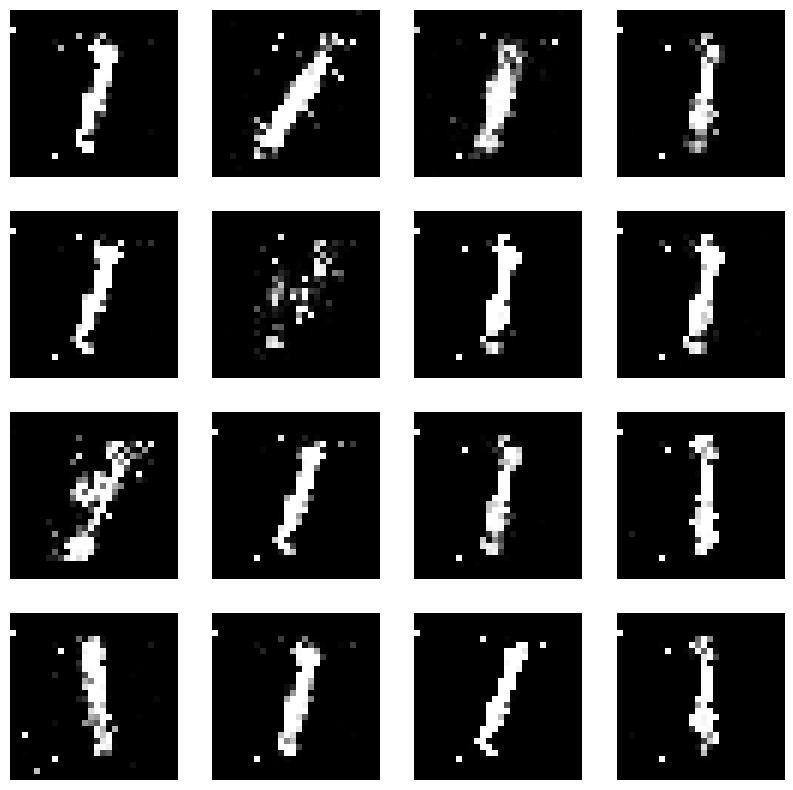

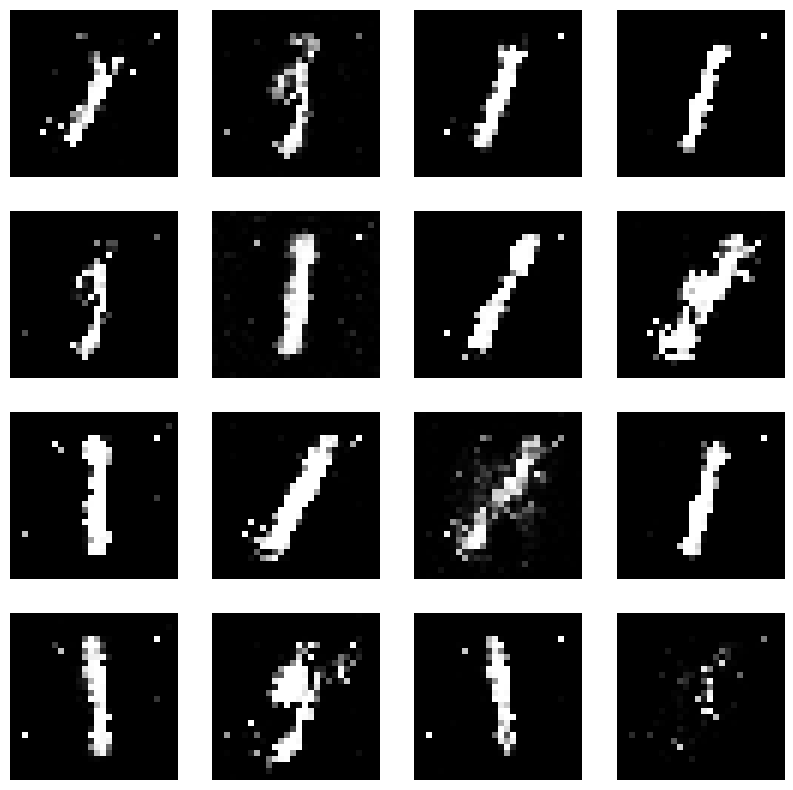

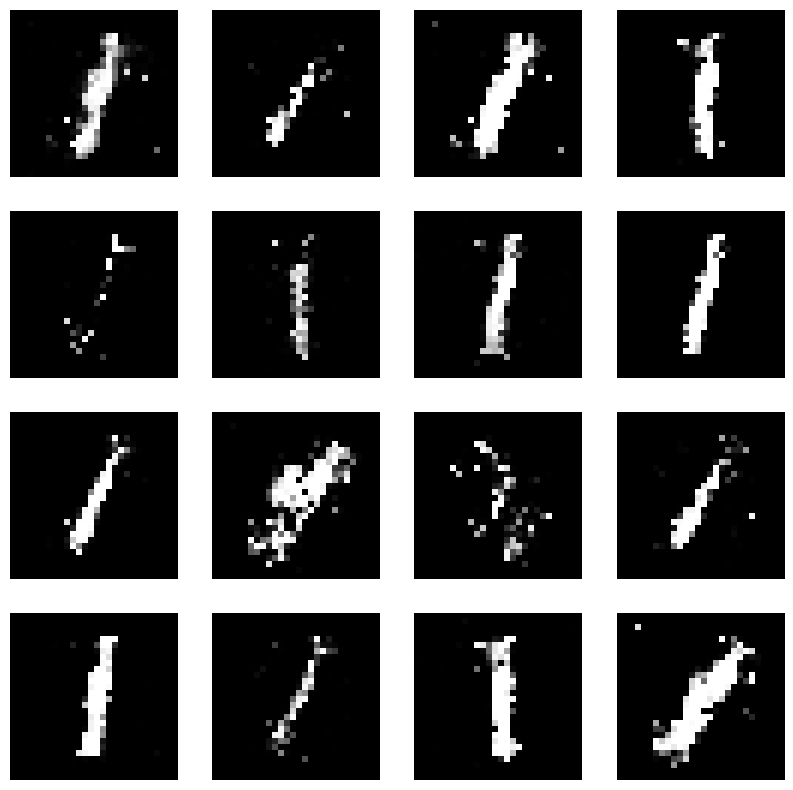

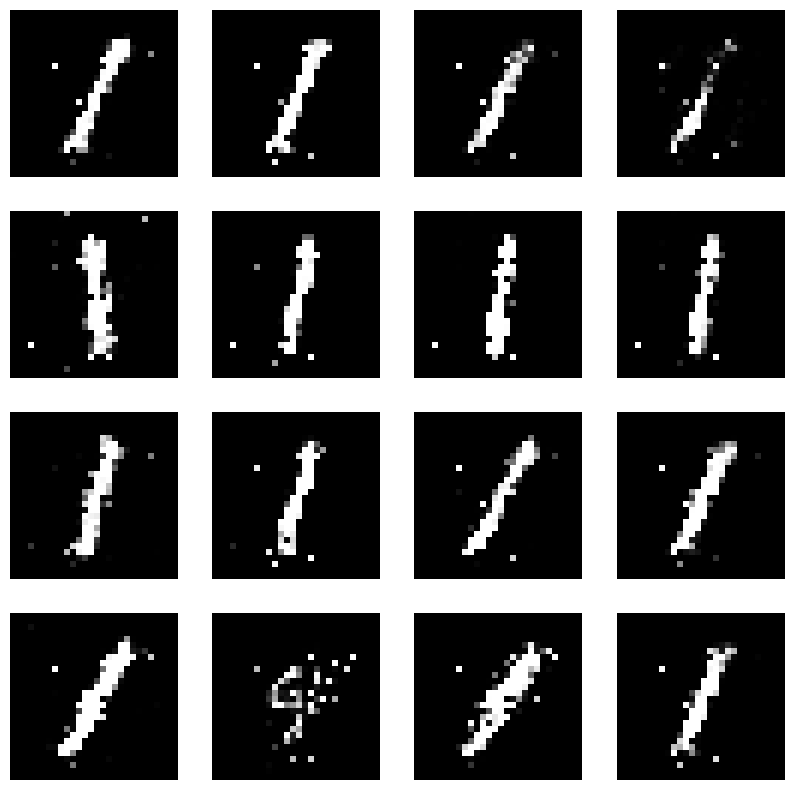

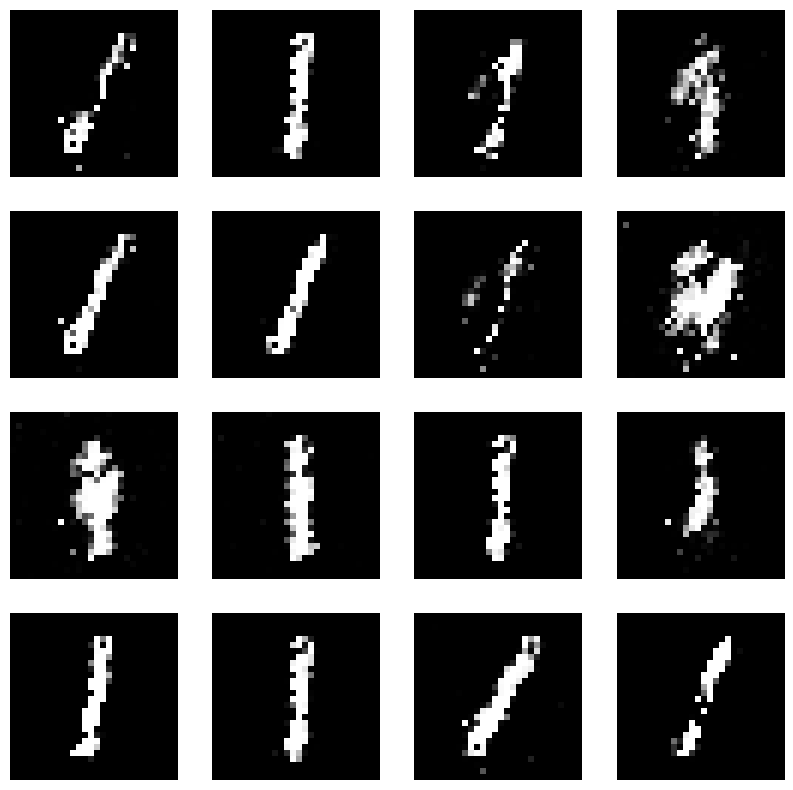

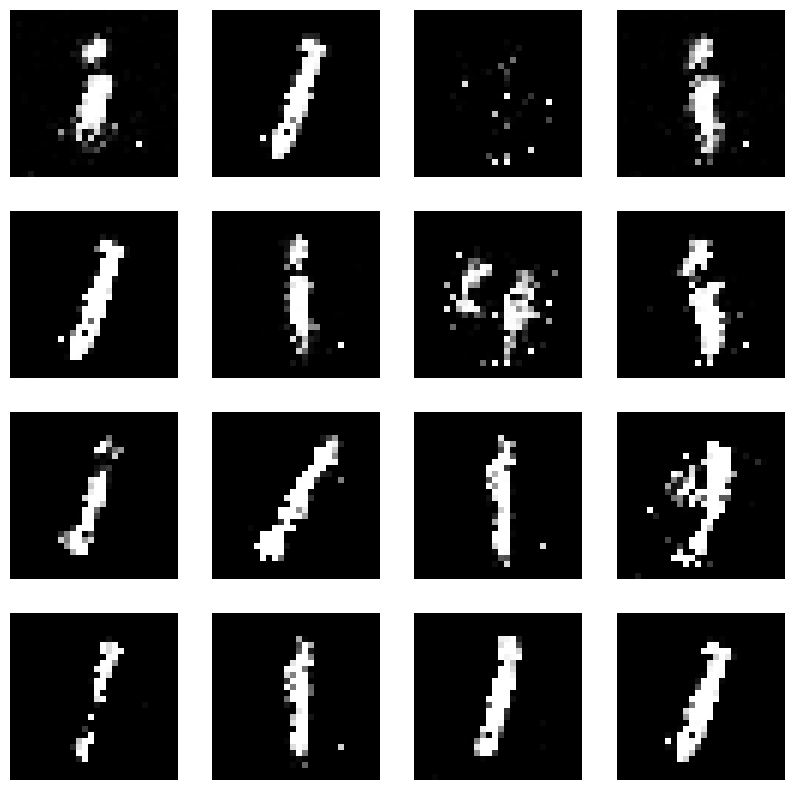

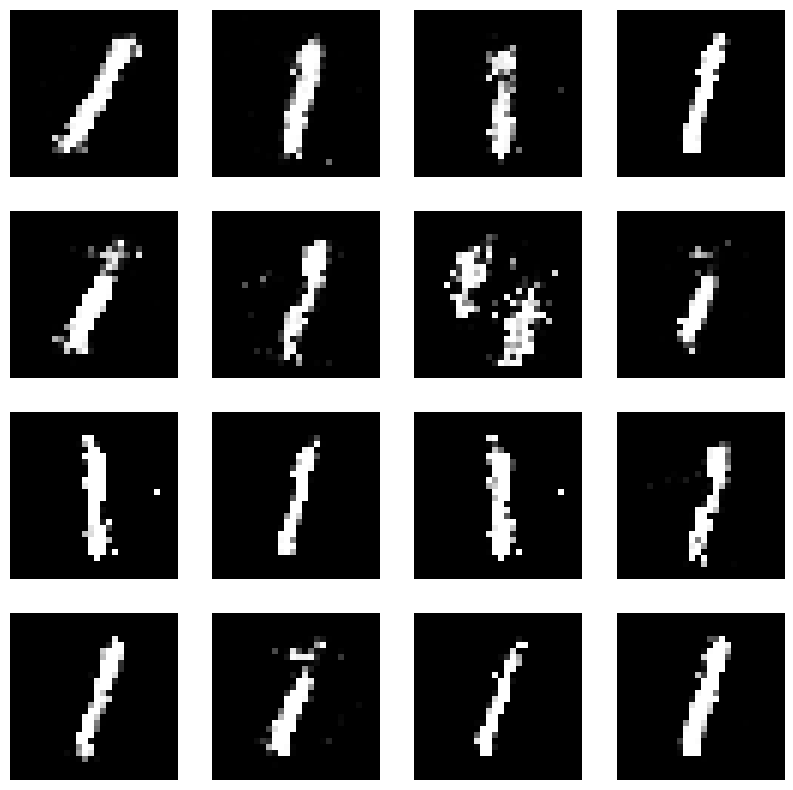

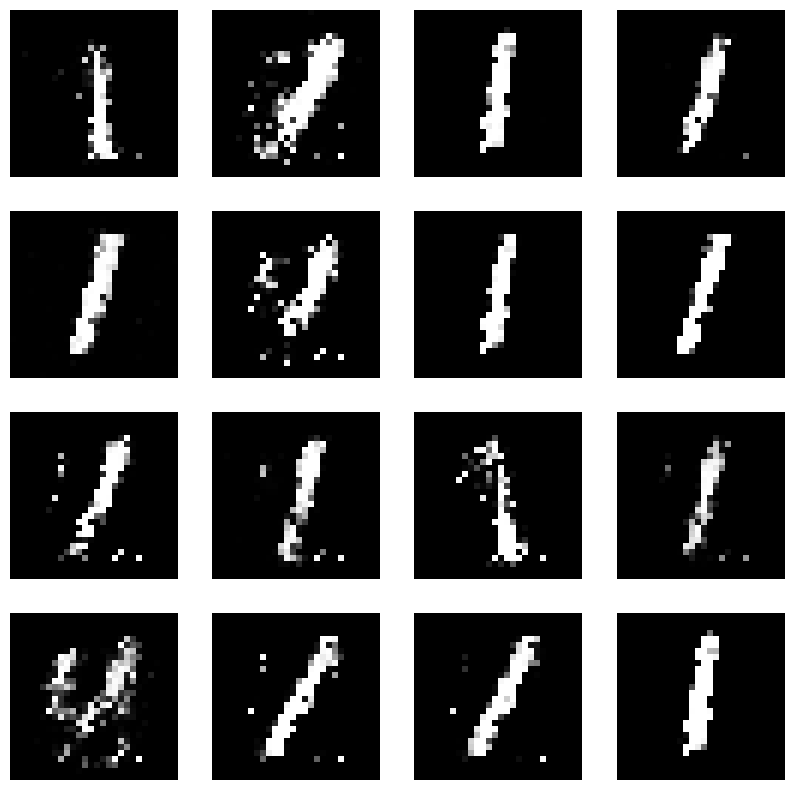

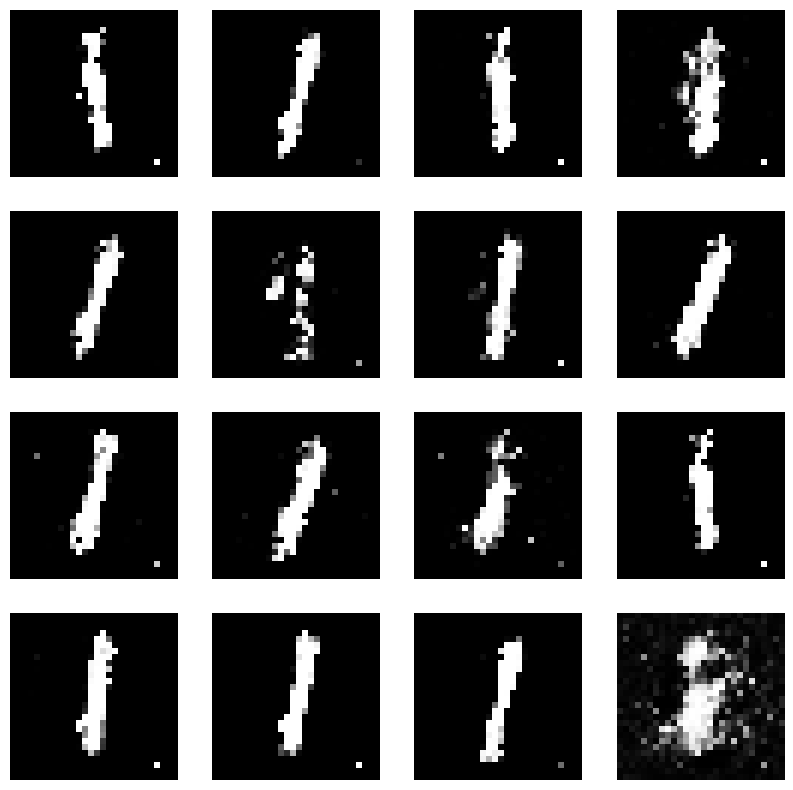

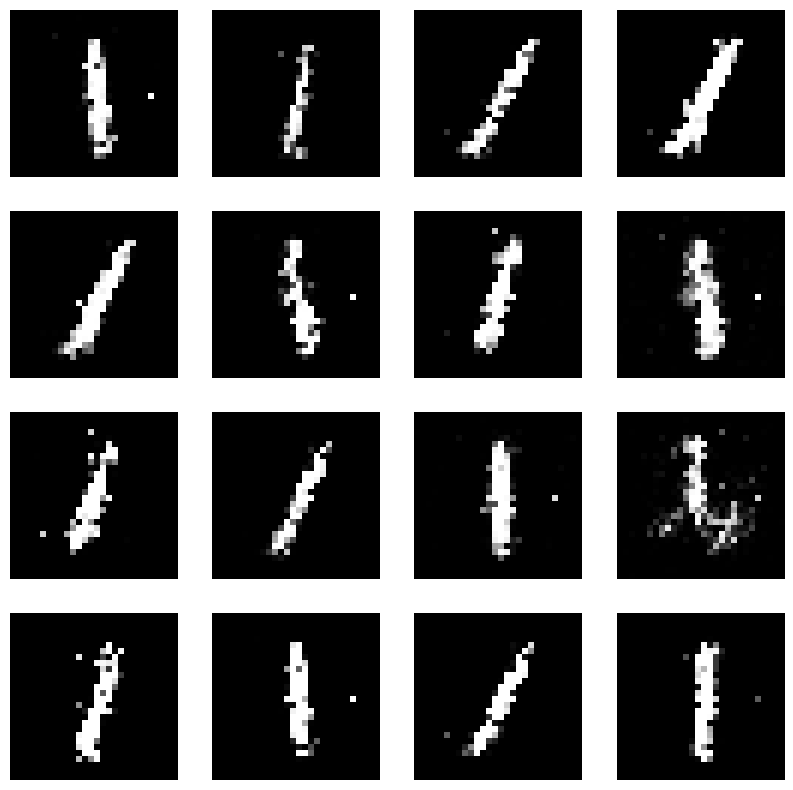

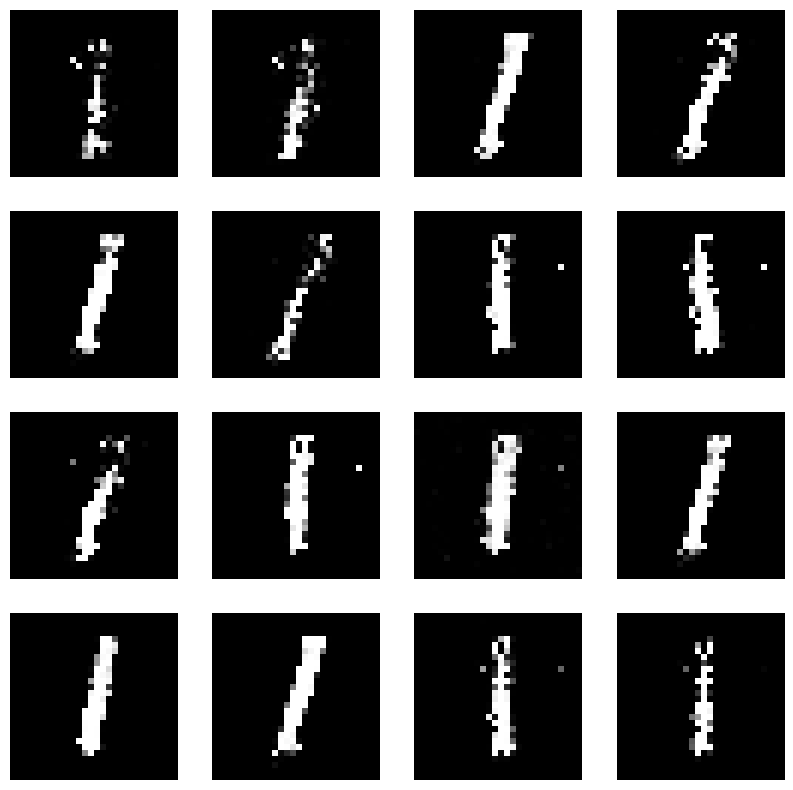

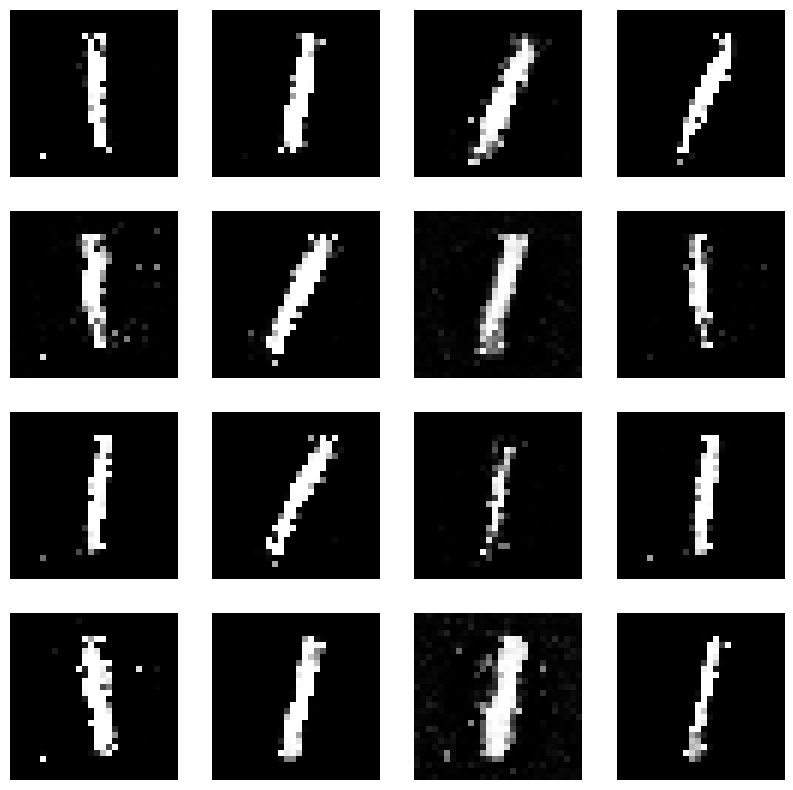

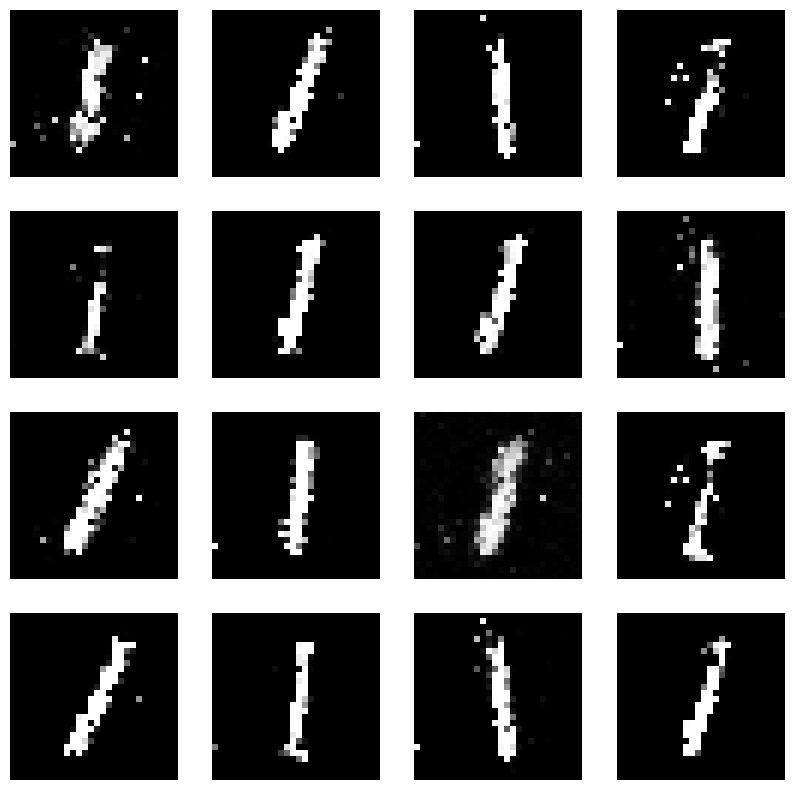

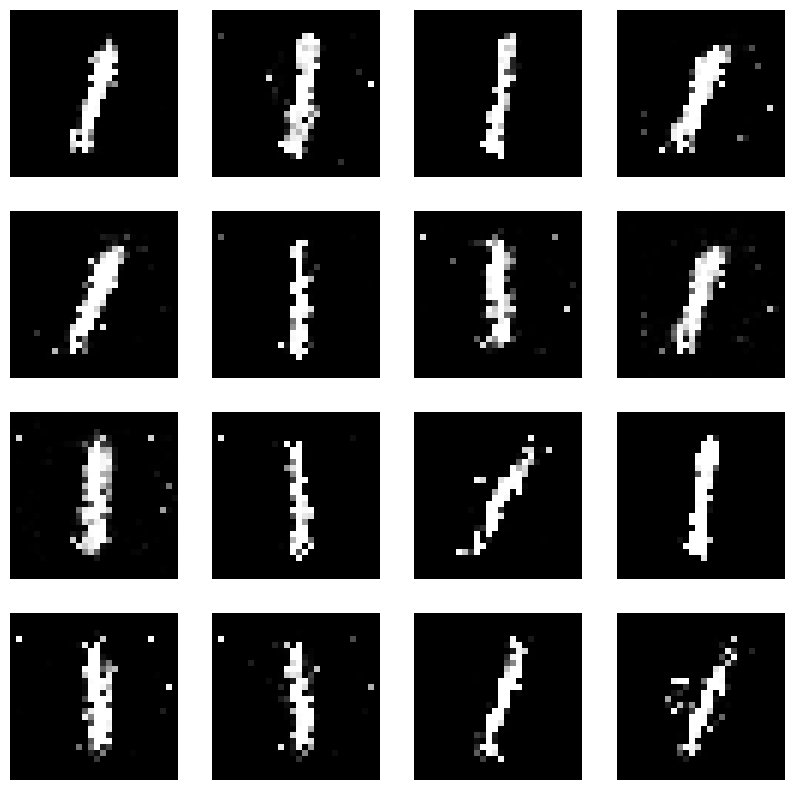

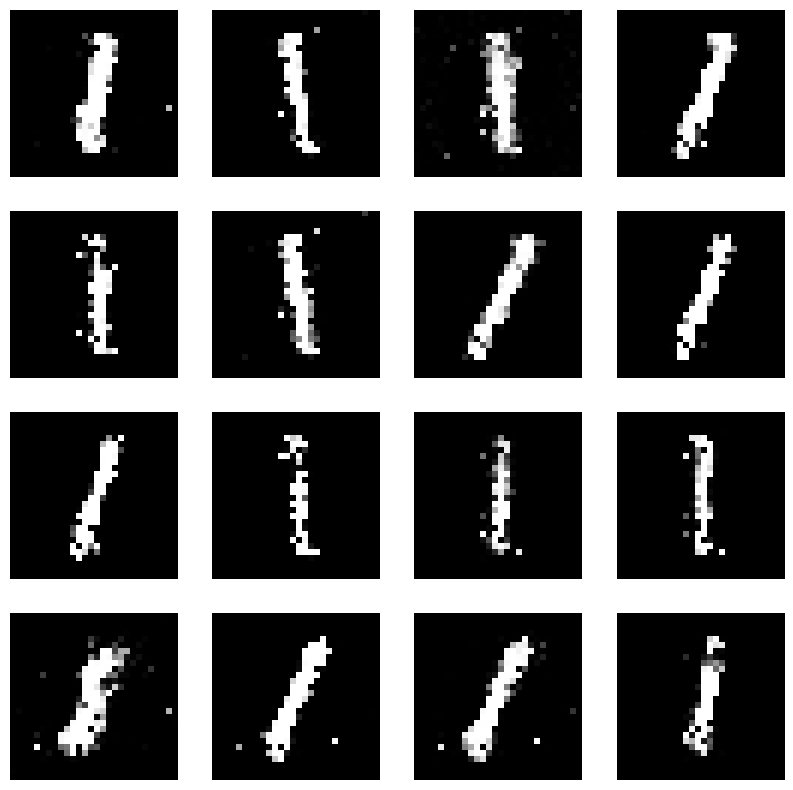

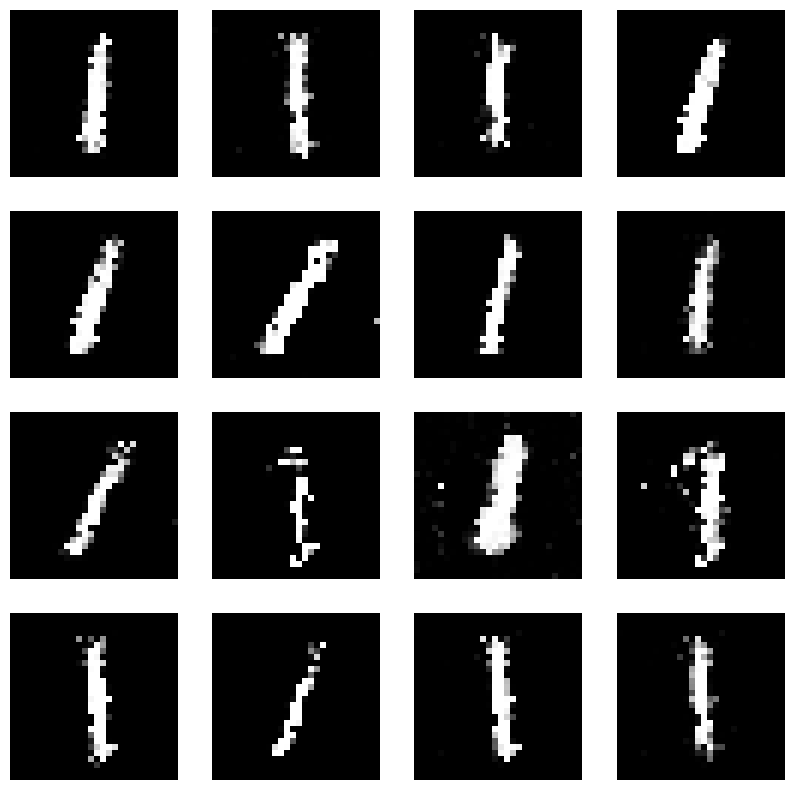

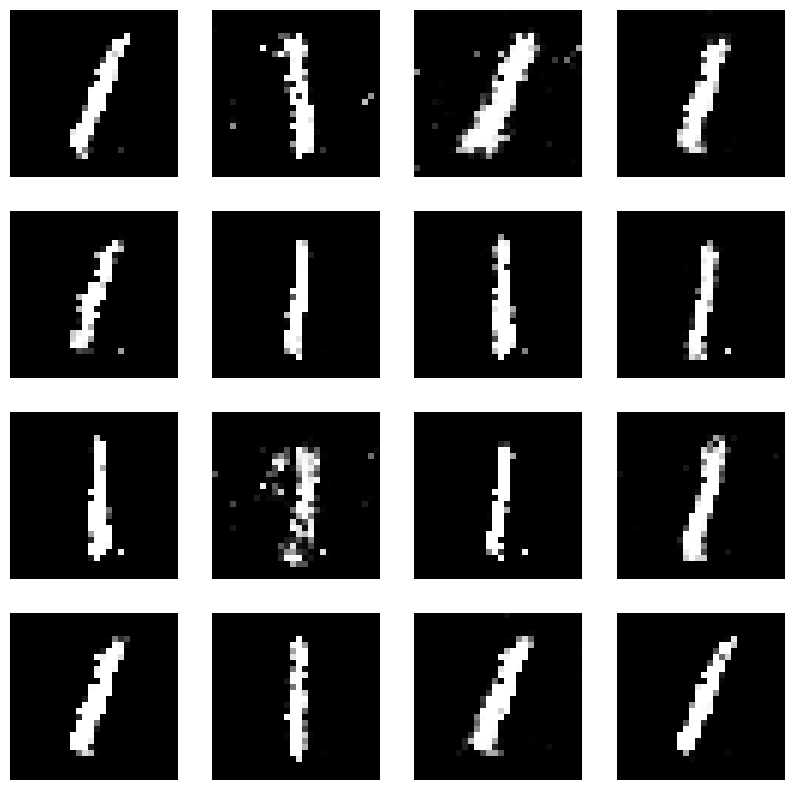

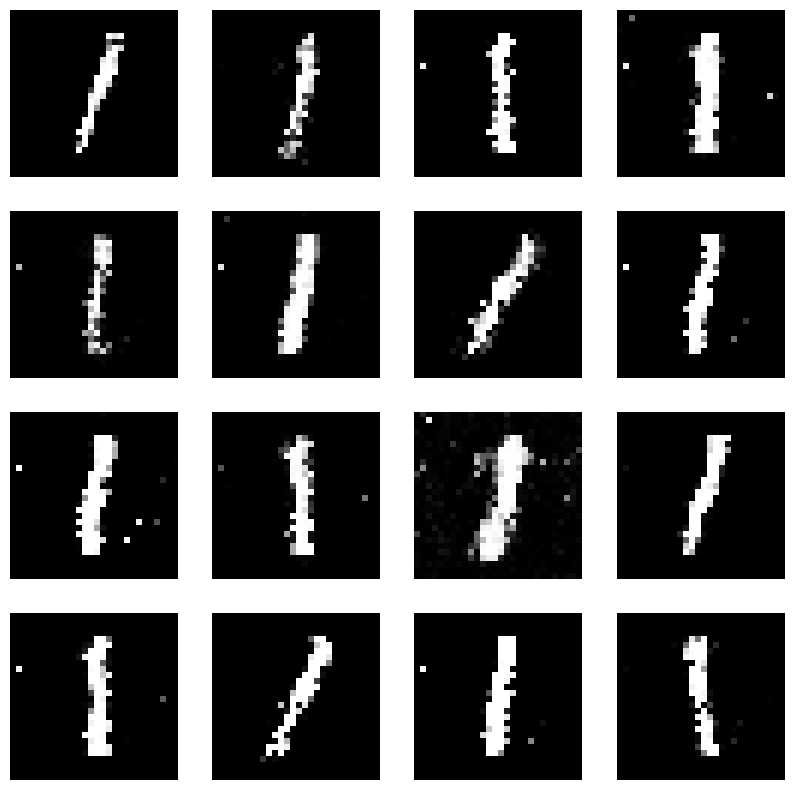

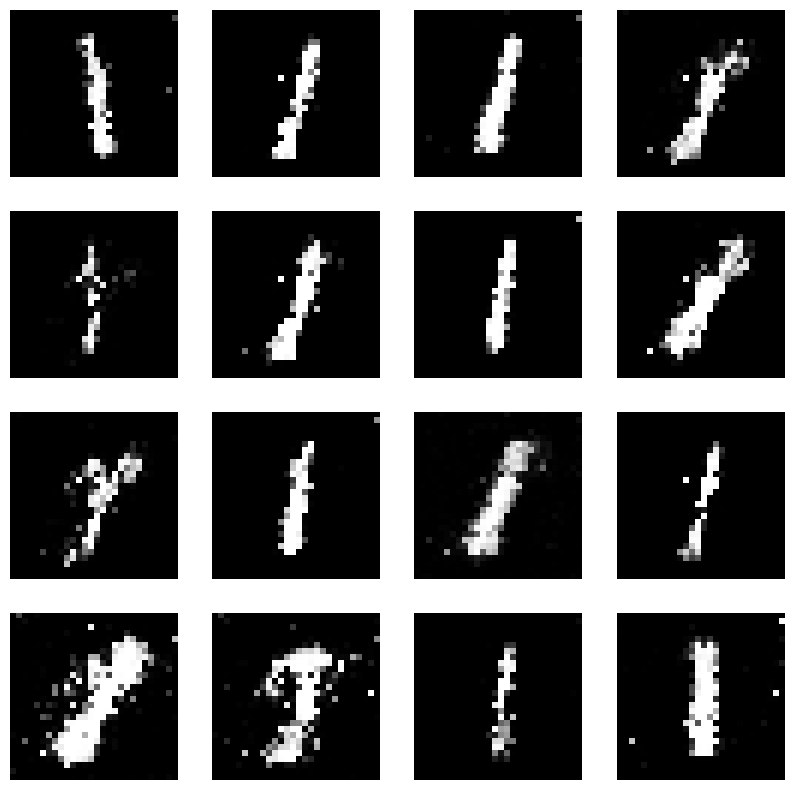

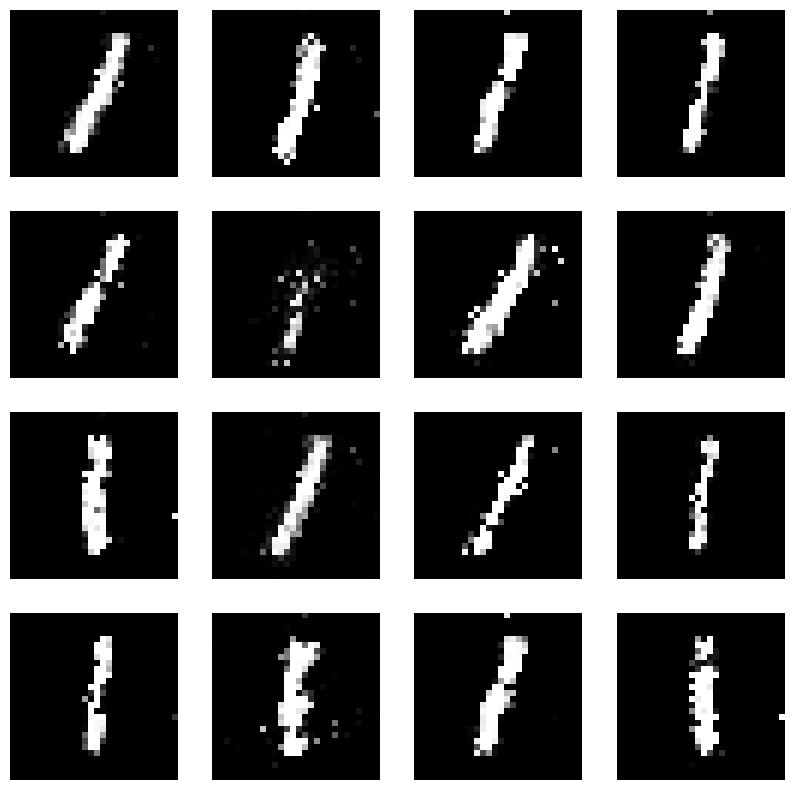

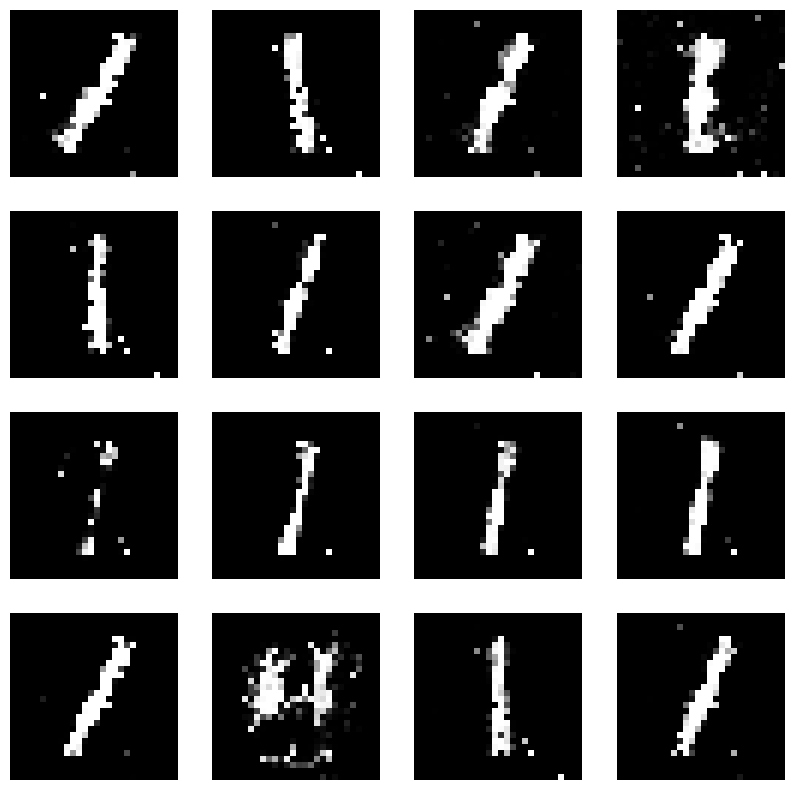

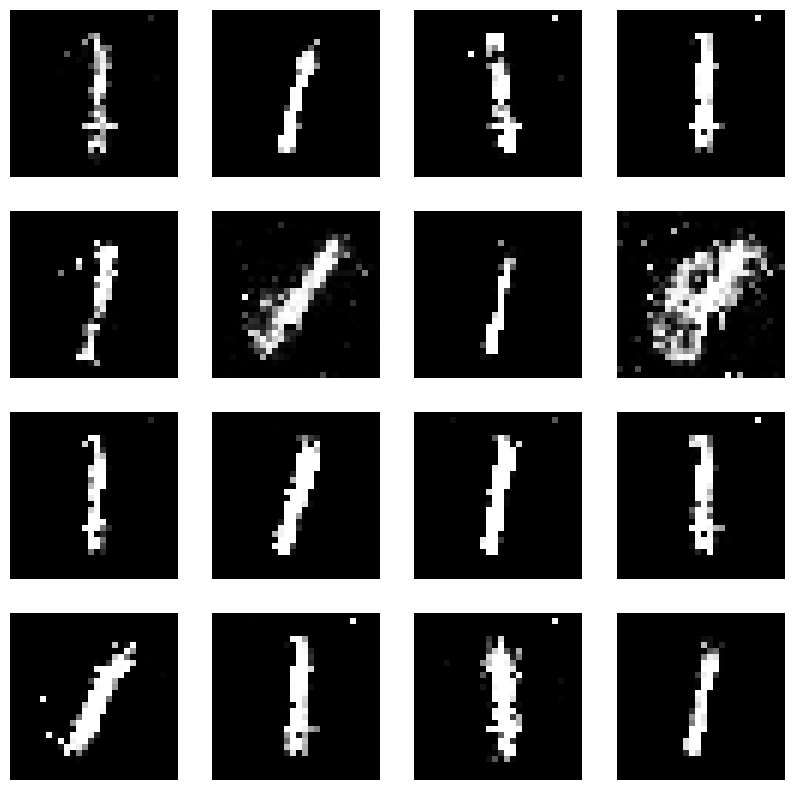

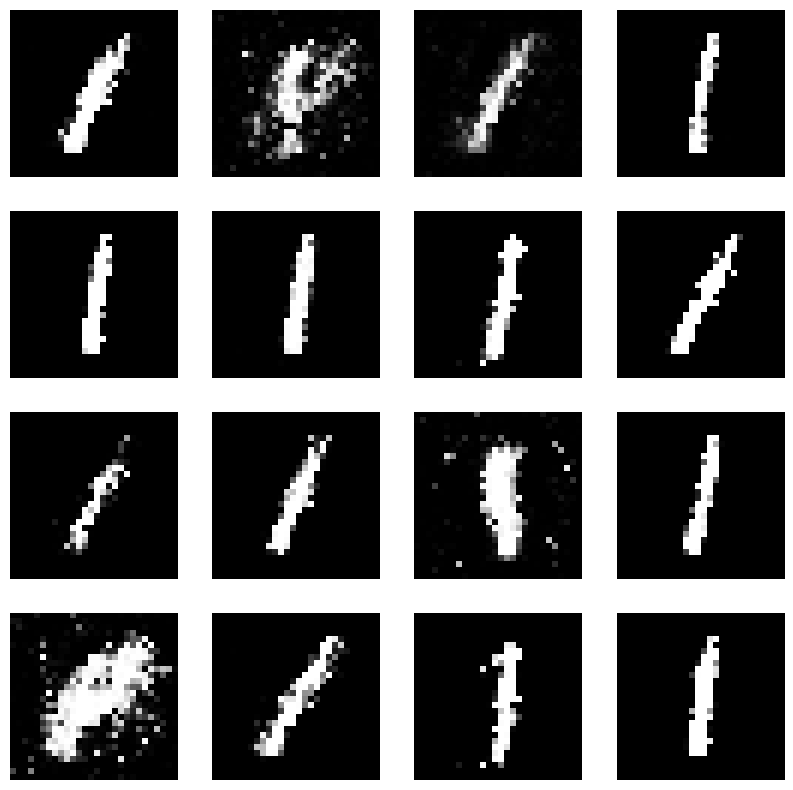

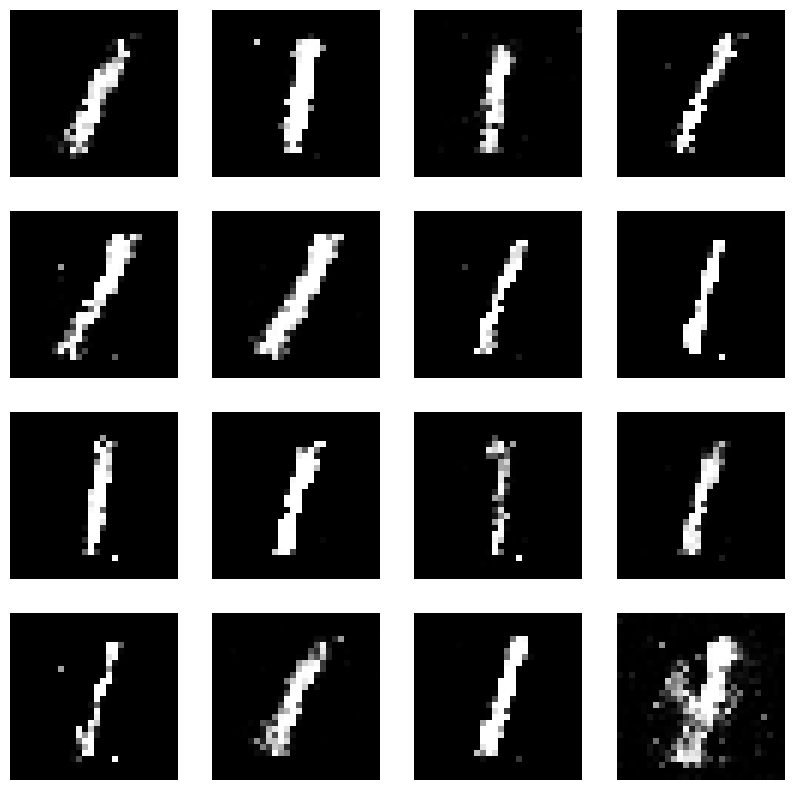

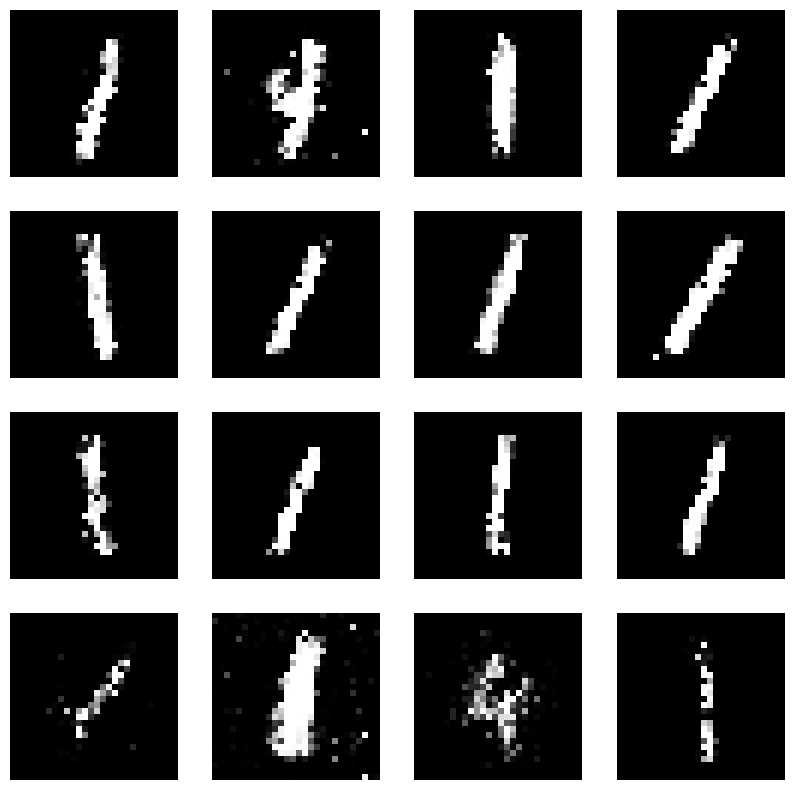

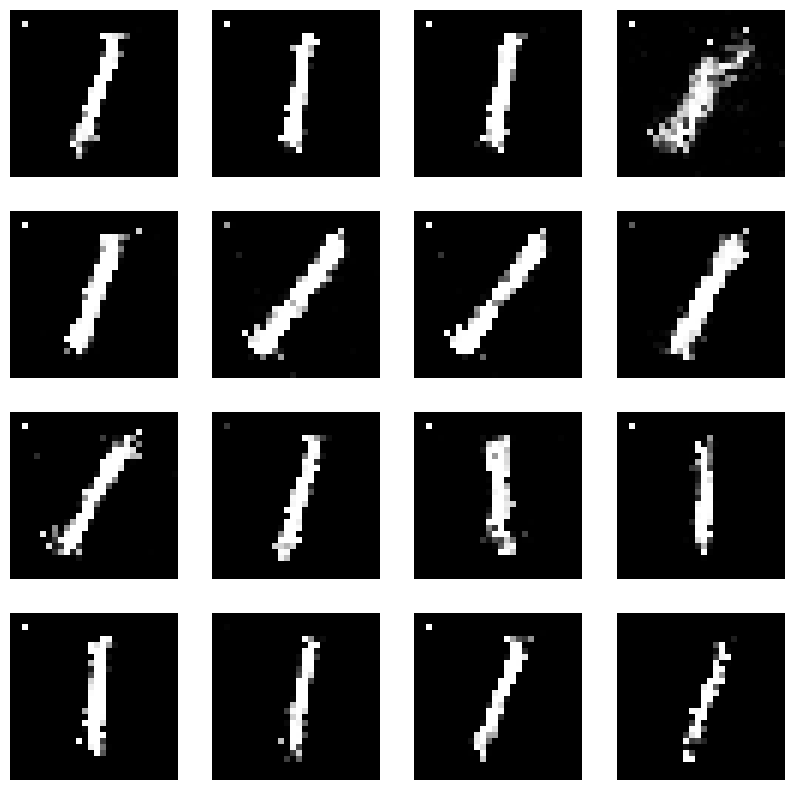

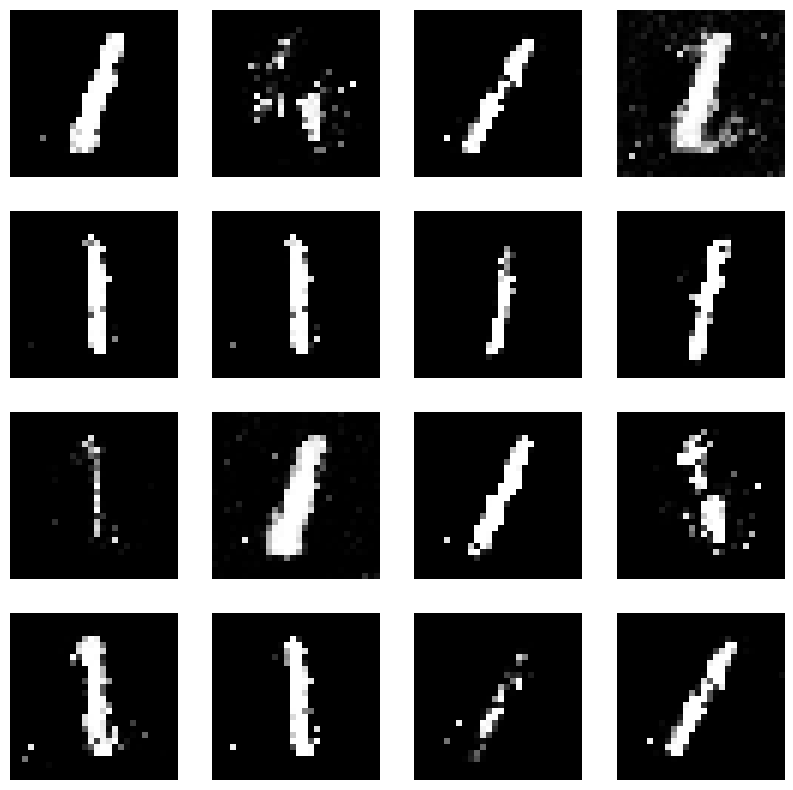

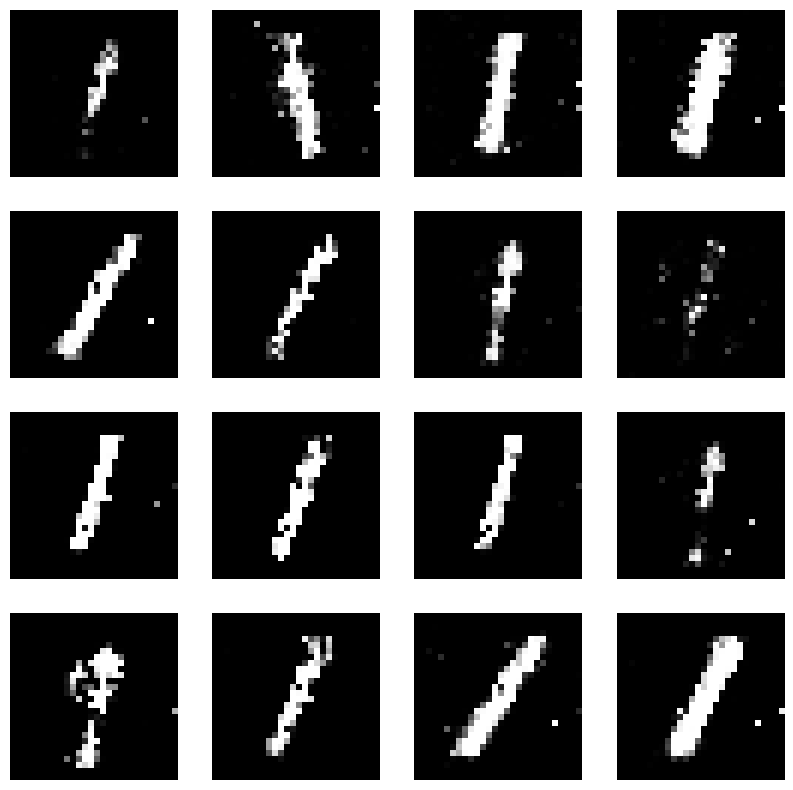

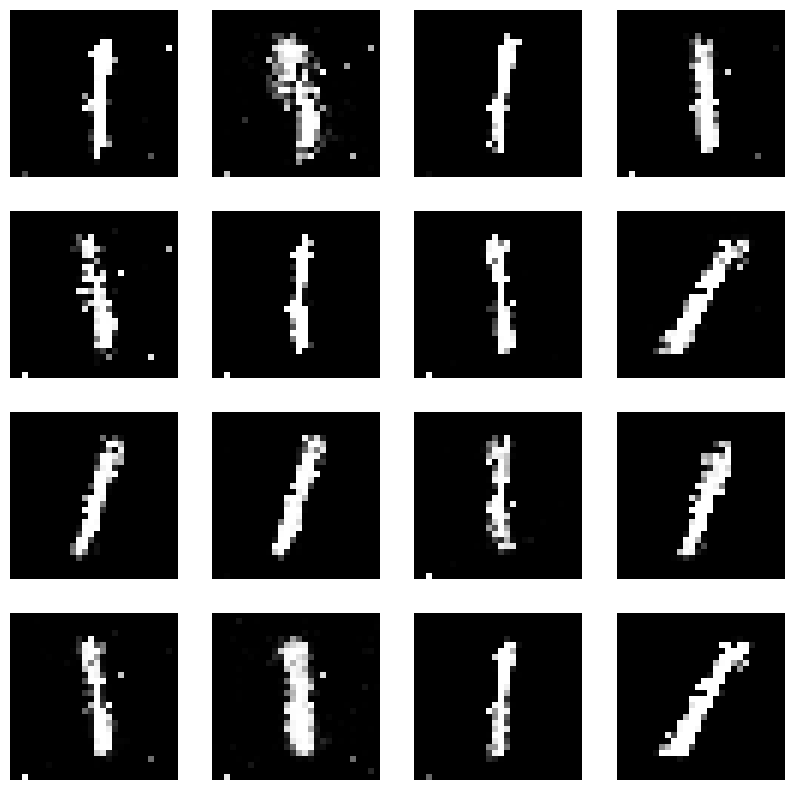

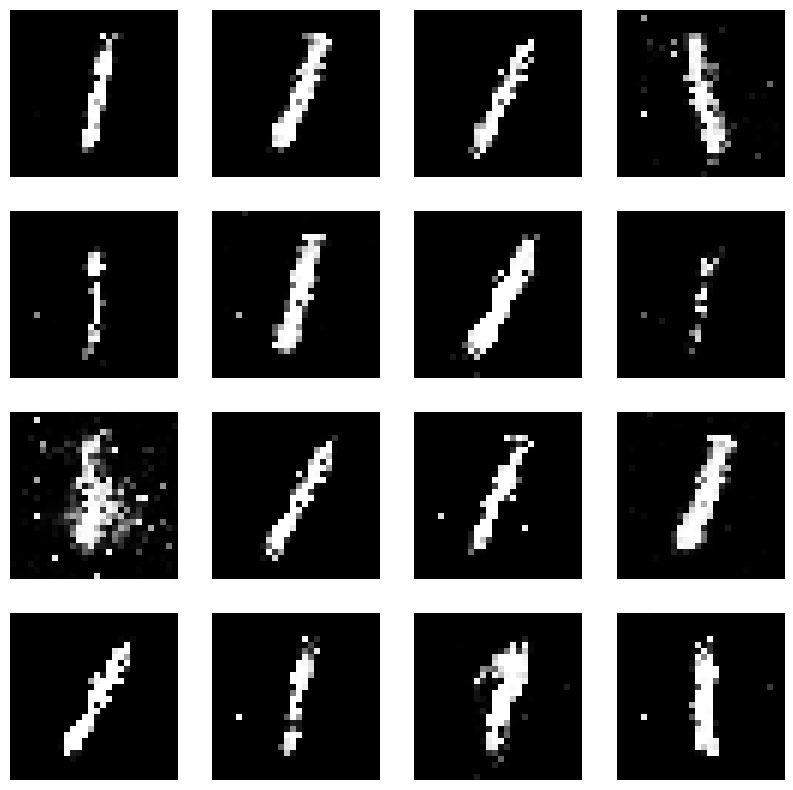

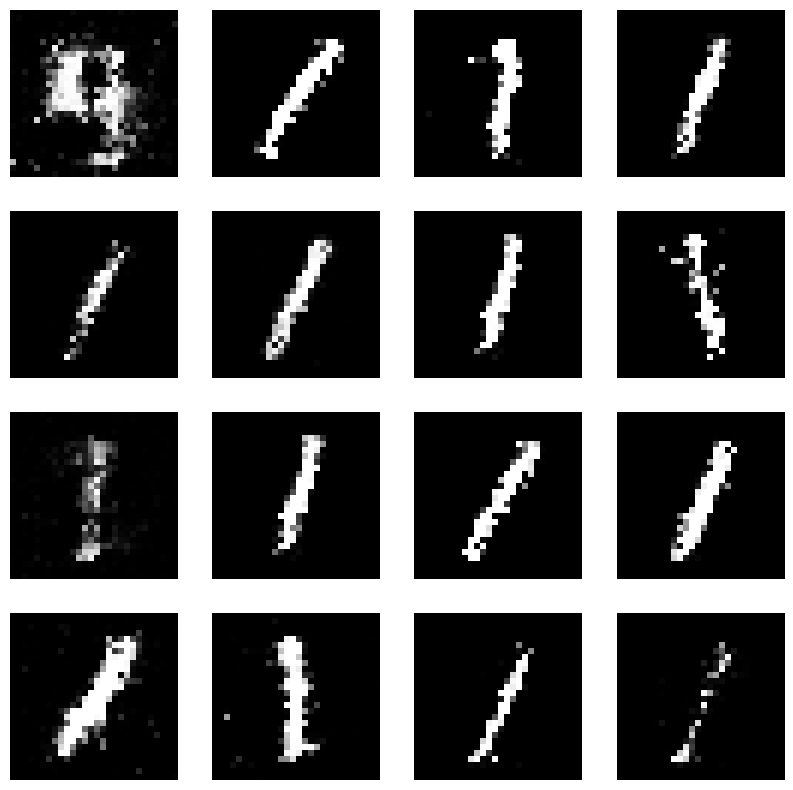

In [ ]:
def train_dcgan():
  """ Train the DCGAN. """
  # record start time
  start = time.time()

  # Make directory for unique run
  make_directory_for_run()
  # Set fixed random number seed
  torch.manual_seed(42)
  # Get prepared dataset
  dataloader = prepare_dataset()
  # Initialize models
  generator, discriminator = initialize_models()
  # Initialize loss and optimizers
  loss_function = initialize_loss()
  generator_optimizer, discriminator_optimizer = initialize_optimizers(generator, discriminator)
  # Train the model
  for epoch in range(NUM_EPOCHS):
    print(f'Starting epoch {epoch}...')
    perform_epoch(dataloader, generator, discriminator, loss_function, \
      generator_optimizer, discriminator_optimizer, epoch)

  # record end time
  end = time.time()
  print(f'Total time: {end - start}')
  # Finished :-)
  print(f'Finished unique run {UNIQUE_RUN_ID}')



if __name__ == '__main__':
  train_dcgan()

